# Data Dictionary

## [Link to download dataset!](https://www.kaggle.com/datasets/dgawlik/nyse)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-za14{border-color:inherit;text-align:left;vertical-align:bottom}
.tg .tg-7zrl{text-align:left;vertical-align:bottom}
</style>
<table class="tg"><thead>
  <tr>
    <th class="tg-za14">Field Name</th>
    <th class="tg-7zrl">Description</th>
    <th class="tg-7zrl">Data Type</th>
  </tr></thead>
<tbody>
  <tr>
    <td class="tg-7zrl">date</td>
    <td class="tg-7zrl">The date range for each data entry. This appears to be a combined string of start and end dates.</td>
    <td class="tg-7zrl">Text</td>
  </tr>
  <tr>
    <td class="tg-7zrl">DateTimeCount</td>
    <td class="tg-7zrl">The count of DateTime entries within the specified date range.</td>
    <td class="tg-7zrl">Numeric (Integer)</td>
  </tr>
  <tr>
    <td class="tg-7zrl">symbol</td>
    <td class="tg-7zrl">An identifier or code, possibly for a financial instrument or category.</td>
    <td class="tg-7zrl">Text</td>
  </tr>
  <tr>
    <td class="tg-7zrl">open</td>
    <td class="tg-7zrl">The opening price/value for a given period.</td>
    <td class="tg-7zrl">Numeric (Float)</td>
  </tr>
  <tr>
    <td class="tg-7zrl">close</td>
    <td class="tg-7zrl">The closing price/value for a given period.</td>
    <td class="tg-7zrl">Numeric (Float)</td>
  </tr>
  <tr>
    <td class="tg-7zrl">low</td>
    <td class="tg-7zrl">The lowest price/value recorded within a given period.</td>
    <td class="tg-7zrl">Numeric (Float)</td>
  </tr>
  <tr>
    <td class="tg-7zrl">high</td>
    <td class="tg-7zrl">The highest price/value recorded within a given period.</td>
    <td class="tg-7zrl">Numeric (Float)</td>
  </tr>
  <tr>
    <td class="tg-7zrl">volume</td>
    <td class="tg-7zrl">The trading volume (number of units traded) within a given period.</td>
    <td class="tg-7zrl">Numeric (Integer)</td>
  </tr>
</tbody></table>

# Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/nyse/securities.csv


In [2]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Suppress the specific FutureWarning from seaborn._oldcore
warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn._oldcore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

2025-07-25 01:43:50.917194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753407831.196020      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753407831.282435      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
Keras Version: 3.8.0


# Load Dataset

In [3]:
df = pd.read_csv('/kaggle/input/nyse/prices-split-adjusted.csv')
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


# Split dataset into train and test

In [4]:
# --- Chronological Split ---
# First, ensure the DataFrame is sorted by date
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

test_size_ratio = 0.2 # 20% for test set
split_point = int(len(df) * (1 - test_size_ratio))

train = df.iloc[:split_point].copy()
test = df.iloc[split_point:].copy()

print("\nData split chronologically by 'date' column:")
print(f"Train DataFrame shape: {train.shape}")
print(f"Test DataFrame shape: {test.shape}")


Data split chronologically by 'date' column:
Train DataFrame shape: (681011, 7)
Test DataFrame shape: (170253, 7)


In [5]:
# Sort train dataframe based on date column from less value to more value
train = train.sort_values(by='date').reset_index(drop=True)
test = test.sort_values(by='date').reset_index(drop=True)

# Data Visualization

## Select one stock for creating model

In [6]:
train = train[train.symbol == 'EQIX'].copy()
test = test[test.symbol == 'EQIX'].copy()
# Sort train dataframe based on date column from less value to more value
train = train.sort_values(by='date').reset_index(drop=True)
test = test.sort_values(by='date').reset_index(drop=True)
train

,date,symbol,open,close,low,high,volume
0,2010-01-04,EQIX,106.519997,109.559998,106.510002,109.620003,576300.0
1,2010-01-05,EQIX,109.589996,108.540001,108.379997,109.589996,681900.0
2,2010-01-06,EQIX,108.949997,109.529999,108.220001,110.570000,1397500.0
3,2010-01-07,EQIX,109.250000,107.290001,106.639999,110.349998,797200.0
4,2010-01-08,EQIX,106.800003,106.769997,105.900002,107.279999,432400.0
...,...,...,...,...,...,...,...
1417,2015-08-20,EQIX,284.220001,279.959991,279.920013,284.649994,568700.0
1418,2015-08-21,EQIX,277.160004,271.309998,271.309998,279.790009,1271900.0
1419,2015-08-24,EQIX,260.000000,255.529999,251.000000,267.089996,1306700.0
1420,2015-08-25,EQIX,260.309998,251.110001,250.860001,263.670013,1294200.0


## Basic Information

In [7]:
train.head()

,date,symbol,open,close,low,high,volume
0,2010-01-04,EQIX,106.519997,109.559998,106.510002,109.620003,576300.0
1,2010-01-05,EQIX,109.589996,108.540001,108.379997,109.589996,681900.0
2,2010-01-06,EQIX,108.949997,109.529999,108.220001,110.570000,1397500.0
3,2010-01-07,EQIX,109.250000,107.290001,106.639999,110.349998,797200.0
4,2010-01-08,EQIX,106.800003,106.769997,105.900002,107.279999,432400.0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1422 non-null   object 
 1   symbol  1422 non-null   object 
 2   open    1422 non-null   float64
 3   close   1422 non-null   float64
 4   low     1422 non-null   float64
 5   high    1422 non-null   float64
 6   volume  1422 non-null   float64
dtypes: float64(5), object(2)
memory usage: 77.9+ KB


In [9]:
train.describe()

,open,close,low,high,volume
count,1422.000000,1422.000000,1422.000000,1422.000000,1.422000e+03
mean,160.671779,160.734803,158.748868,162.544423,9.128723e+05
std,57.769144,57.761722,57.255626,58.169847,1.064773e+06
min,71.750000,70.339996,69.419998,74.510002,1.524000e+05
25%,98.382502,98.502500,97.042500,99.649997,5.338000e+05
50%,173.614998,173.385002,170.770004,176.120003,7.309500e+05
75%,210.034996,210.097504,208.022495,212.072502,1.040200e+06
max,286.130005,287.420013,283.980011,288.500000,3.057420e+07


## Trend of stock

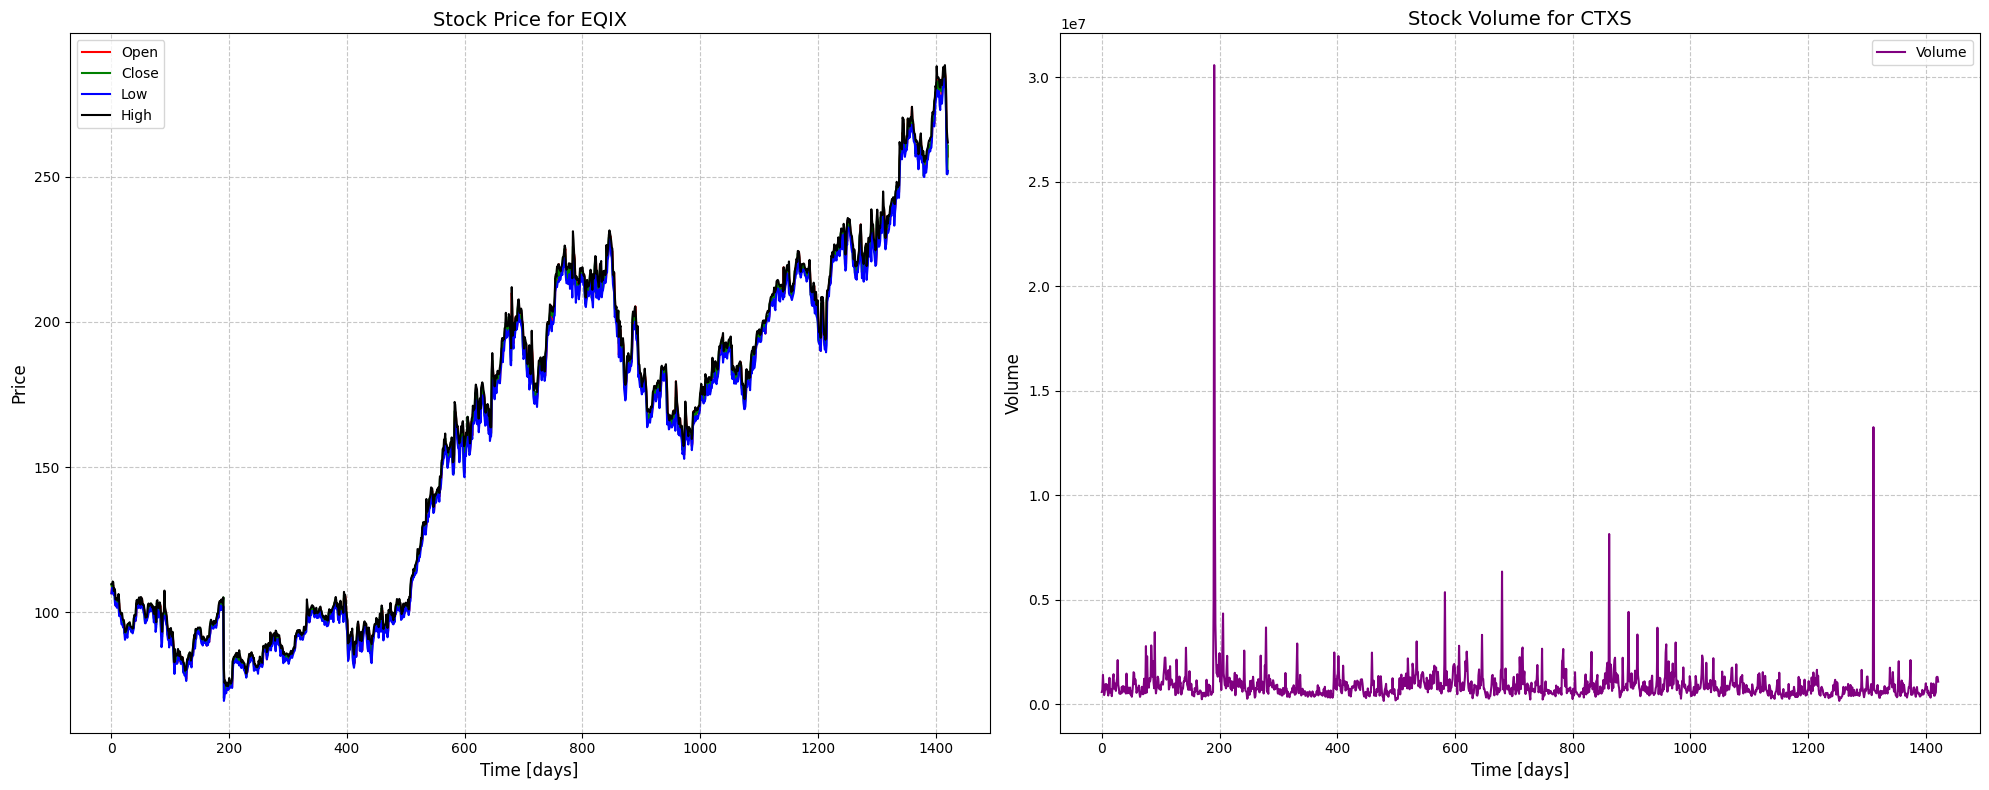

In [10]:
# For plotting, it's often easier to use a numerical index for 'time [days]'
train['time_idx'] = range(len(train))

# Filter the DataFrame for the 'CTXS' symbol
ctxs_data = train[train.symbol == 'EQIX']

# --- Plotting with Seaborn ---
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # Adjusted figure size for better side-by-side view

# Subplot 1: Stock Prices
# Use sns.lineplot for each price type
sns.lineplot(x='time_idx', y='open', data=ctxs_data, color='red', label='Open', ax=axes[0])
sns.lineplot(x='time_idx', y='close', data=ctxs_data, color='green', label='Close', ax=axes[0])
sns.lineplot(x='time_idx', y='low', data=ctxs_data, color='blue', label='Low', ax=axes[0])
sns.lineplot(x='time_idx', y='high', data=ctxs_data, color='black', label='High', ax=axes[0])

axes[0].set_title('Stock Price for EQIX', fontsize=14)
axes[0].set_xlabel('Time [days]', fontsize=12)
axes[0].set_ylabel('Price', fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(True, linestyle='--', alpha=0.7) # Add grid for better readability

# Subplot 2: Stock Volume
sns.lineplot(x='time_idx', y='volume', data=ctxs_data, color='purple', label='Volume', ax=axes[1]) # Changed color for distinction

axes[1].set_title('Stock Volume for CTXS', fontsize=14)
axes[1].set_xlabel('Time [days]', fontsize=12)
axes[1].set_ylabel('Volume', fontsize=12)
axes[1].legend(loc='best')
axes[1].grid(True, linestyle='--', alpha=0.7) # Add grid for better readability

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

## Correlation analysis

In [11]:
train = train.drop(columns=['symbol'])
test = test.drop(columns=['symbol'])
train

,date,open,close,low,high,volume,time_idx
0,2010-01-04,106.519997,109.559998,106.510002,109.620003,576300.0,0
1,2010-01-05,109.589996,108.540001,108.379997,109.589996,681900.0,1
2,2010-01-06,108.949997,109.529999,108.220001,110.570000,1397500.0,2
3,2010-01-07,109.250000,107.290001,106.639999,110.349998,797200.0,3
4,2010-01-08,106.800003,106.769997,105.900002,107.279999,432400.0,4
...,...,...,...,...,...,...,...
1417,2015-08-20,284.220001,279.959991,279.920013,284.649994,568700.0,1417
1418,2015-08-21,277.160004,271.309998,271.309998,279.790009,1271900.0,1418
1419,2015-08-24,260.000000,255.529999,251.000000,267.089996,1306700.0,1419
1420,2015-08-25,260.309998,251.110001,250.860001,263.670013,1294200.0,1420


In [12]:
# Convert date to datetime format
train['date'] = pd.to_datetime(train['date'])

# Extract numerical features from datetime
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train

,date,open,close,low,high,volume,time_idx,year,month,day
0,2010-01-04,106.519997,109.559998,106.510002,109.620003,576300.0,0,2010,1,4
1,2010-01-05,109.589996,108.540001,108.379997,109.589996,681900.0,1,2010,1,5
2,2010-01-06,108.949997,109.529999,108.220001,110.570000,1397500.0,2,2010,1,6
3,2010-01-07,109.250000,107.290001,106.639999,110.349998,797200.0,3,2010,1,7
4,2010-01-08,106.800003,106.769997,105.900002,107.279999,432400.0,4,2010,1,8
...,...,...,...,...,...,...,...,...,...,...
1417,2015-08-20,284.220001,279.959991,279.920013,284.649994,568700.0,1417,2015,8,20
1418,2015-08-21,277.160004,271.309998,271.309998,279.790009,1271900.0,1418,2015,8,21
1419,2015-08-24,260.000000,255.529999,251.000000,267.089996,1306700.0,1419,2015,8,24
1420,2015-08-25,260.309998,251.110001,250.860001,263.670013,1294200.0,1420,2015,8,25


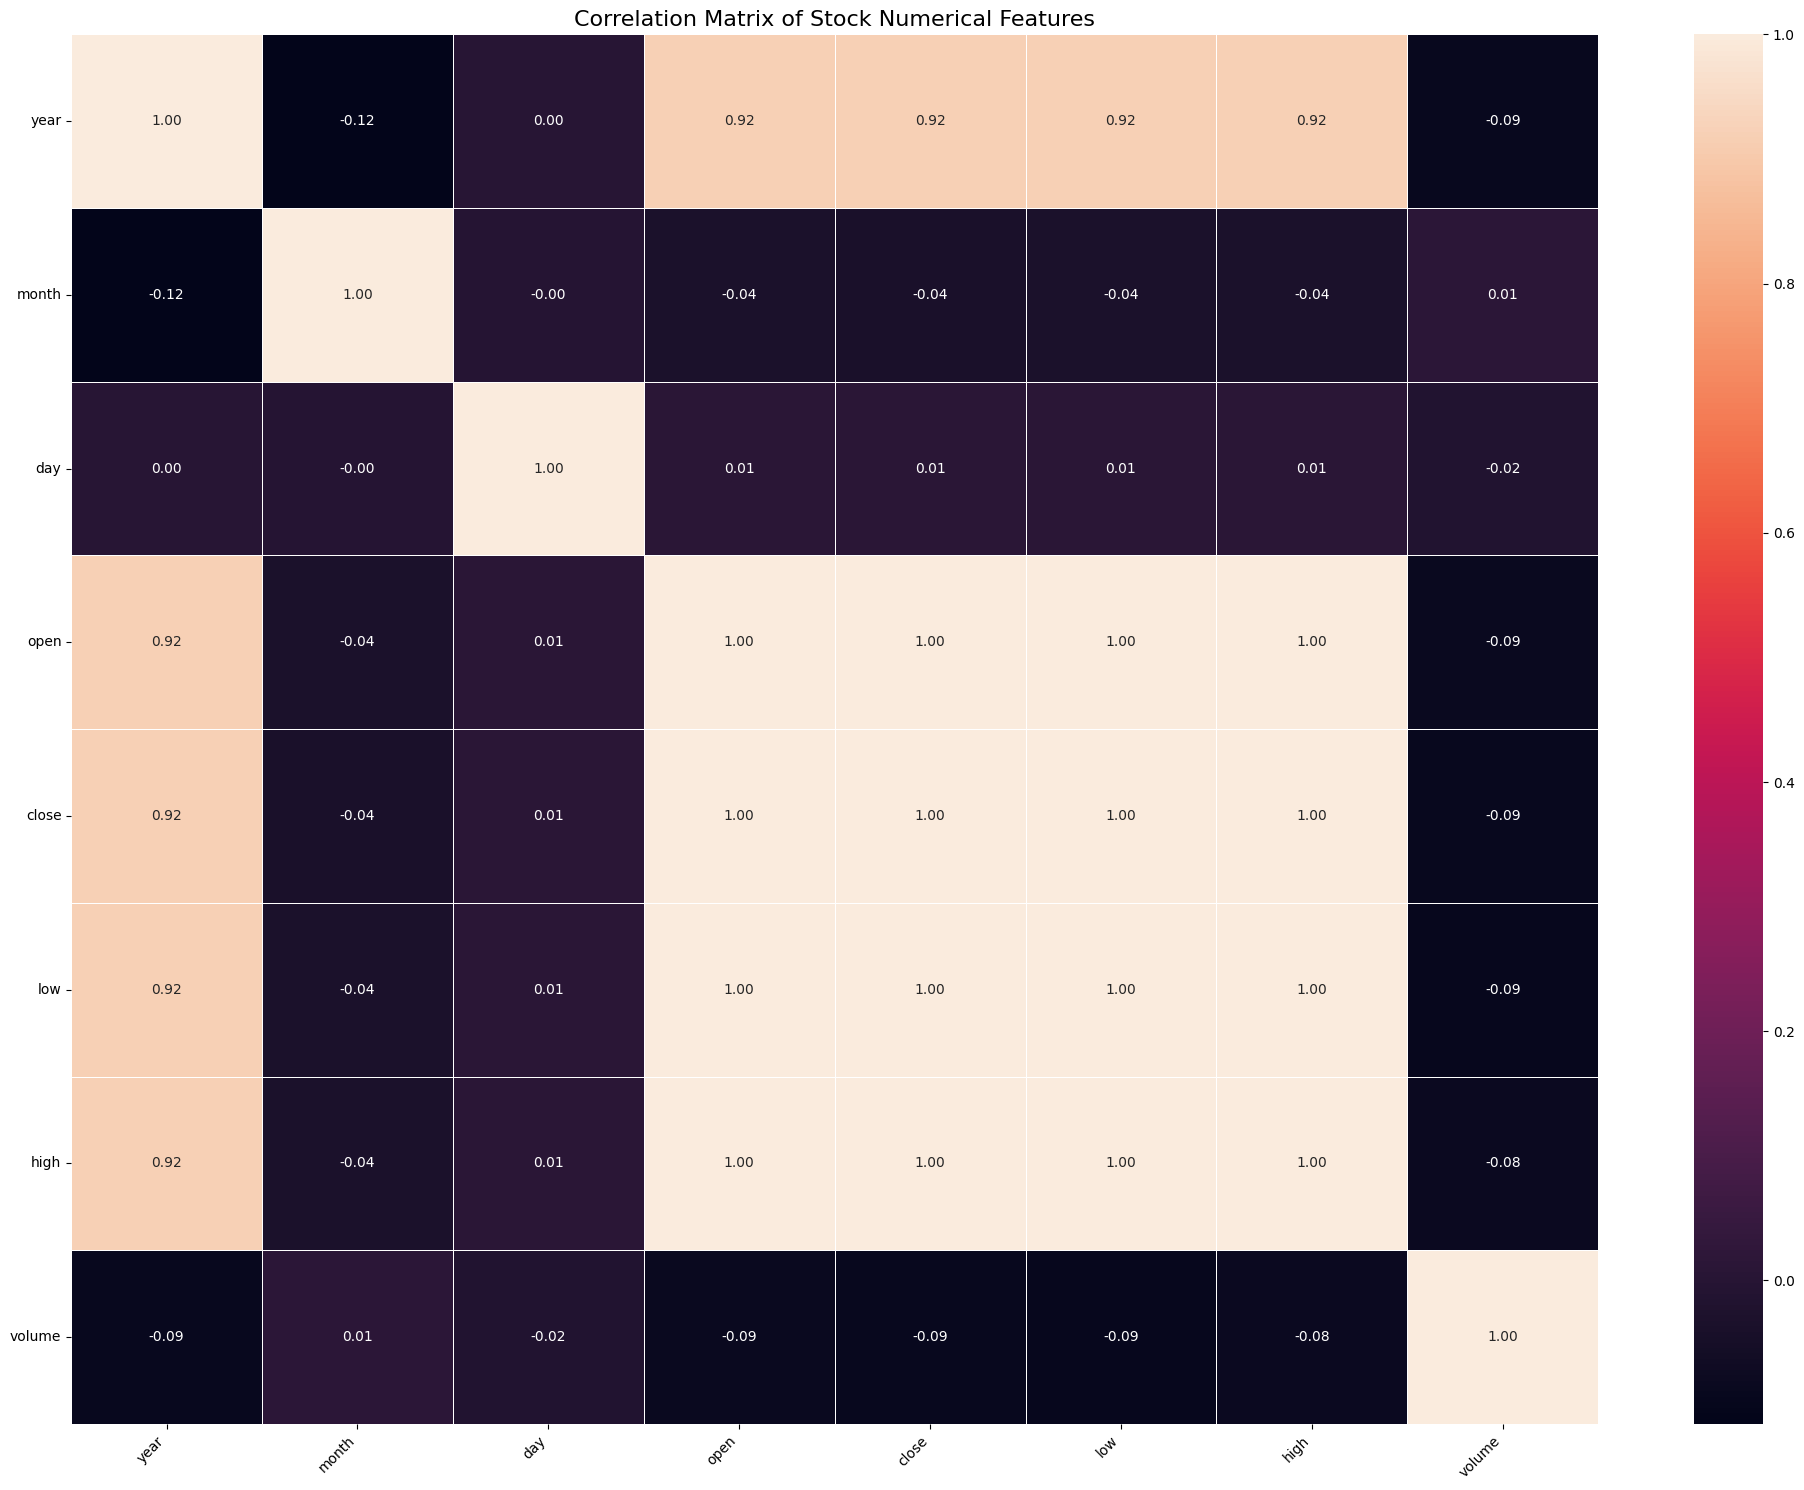


--- Interpretation of the Correlation Heatmap ---
• Values close to 1 indicate a strong positive correlation (as one variable increases, the other tends to increase).
• Values close to -1 indicate a strong negative correlation (as one variable increases, the other tends to decrease).
• Values close to 0 indicate a weak or no linear correlation.
• The diagonal is always 1 because a variable is perfectly correlated with itself.


In [13]:
# Select numerical columns for correlation
numerical_cols = ['year','month','day', 'open', 'close', 'low', 'high', 'volume']

# Calculate Pearson correlation
correlation_matrix = train[numerical_cols].corr(method='pearson')

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(20, 15)) # Set a suitable figure size for the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,      # Show the correlation values on the heatmap
    cmap='rocket', # Colormap: 'coolwarm' is good for showing positive/negative
    fmt=".2f",       # Format annotations to two decimal places
    linewidths=.5    # Add lines between cells
)
plt.title('Correlation Matrix of Stock Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("\n--- Interpretation of the Correlation Heatmap ---")
print("• Values close to 1 indicate a strong positive correlation (as one variable increases, the other tends to increase).")
print("• Values close to -1 indicate a strong negative correlation (as one variable increases, the other tends to decrease).")
print("• Values close to 0 indicate a weak or no linear correlation.")
print("• The diagonal is always 1 because a variable is perfectly correlated with itself.")

# Features Engineering

## Encode date

In [14]:
# Convert date to datetime format
test['date'] = pd.to_datetime(test['date'])

# Extract numerical features from datetime
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test

,date,open,close,low,high,volume,year,month,day
0,2015-08-27,262.089996,266.140015,261.519989,268.179993,704700.0,2015,8,27
1,2015-08-28,264.709991,268.779999,264.489990,270.000000,588600.0,2015,8,28
2,2015-08-31,267.519989,269.769989,265.000000,270.100006,4911600.0,2015,8,31
3,2015-09-01,265.089996,262.869995,260.429993,266.769989,1298200.0,2015,9,1
4,2015-09-02,264.989990,269.950012,263.619995,269.980011,1049100.0,2015,9,2
...,...,...,...,...,...,...,...,...,...
335,2016-12-23,352.100006,356.609985,350.369995,358.140015,338100.0,2016,12,23
336,2016-12-27,356.779999,356.720001,355.109985,359.649994,294600.0,2016,12,27
337,2016-12-28,357.220001,353.859985,353.429993,359.549988,291600.0,2016,12,28
338,2016-12-29,353.420013,357.089996,351.890015,358.929993,372000.0,2016,12,29


## Drop noise columns

In [15]:
train = train.drop(columns=['day','date','time_idx'])
test = test.drop(columns=['day','date'])
train

,open,close,low,high,volume,year,month
0,106.519997,109.559998,106.510002,109.620003,576300.0,2010,1
1,109.589996,108.540001,108.379997,109.589996,681900.0,2010,1
2,108.949997,109.529999,108.220001,110.570000,1397500.0,2010,1
3,109.250000,107.290001,106.639999,110.349998,797200.0,2010,1
4,106.800003,106.769997,105.900002,107.279999,432400.0,2010,1
...,...,...,...,...,...,...,...
1417,284.220001,279.959991,279.920013,284.649994,568700.0,2015,8
1418,277.160004,271.309998,271.309998,279.790009,1271900.0,2015,8
1419,260.000000,255.529999,251.000000,267.089996,1306700.0,2015,8
1420,260.309998,251.110001,250.860001,263.670013,1294200.0,2015,8


## Data Normalization

In [16]:
# --- Min-Max Scaling of Numerical Columns ---
print("\n--- Applying Min-Max Scaling to Numerical Features ---")

numerical_cols = ['open', 'close', 'low', 'high', 'volume']
scaler = MinMaxScaler()

# Fit the scaler on the training data's numerical columns and transform them
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
print("Train DataFrame numerical columns scaled.")

# Transform the test data's numerical columns using the *fitted* scaler
test[numerical_cols] = scaler.transform(test[numerical_cols])
print("Test DataFrame numerical columns transformed.")


--- Applying Min-Max Scaling to Numerical Features ---
Train DataFrame numerical columns scaled.
Test DataFrame numerical columns transformed.


## Create Train, Validation, and Test Data Sequence

In [17]:
# Define percentages for data splitting.
# These percentages are used to determine the sizes of validation sets.
valid_set_size_percentage = 20 # 20% of the training sequences will be used for validation
test_set_size_percentage = 10 # This variable is not directly used for slicing in the current functions,
                              # but is kept for context from the original snippet.

# Function to create train and validation data sequences given stock data and sequence length
def load_data_train(stock, seq_len, valid_set_size_percentage):
    """
    Converts a DataFrame into sequences for training and validation.

    Args:
        stock (pd.DataFrame): The input DataFrame (e.g., your 'train' DataFrame).
        seq_len (int): The length of each sequence.
        valid_set_size_percentage (int): Percentage of data to reserve for validation.

    Returns:
        list: [x_train, y_train, x_valid, y_valid]
              x_train: Training input sequences.
              y_train: Training target values (next step in sequence).
              x_valid: Validation input sequences.
              y_valid: Validation target values (next step in sequence).
    """
    # Fix: .as_matrix() is deprecated, use .values to convert DataFrame to NumPy array
    data_raw = stock.values
    data = []

    # Create all possible sequences of length seq_len
    # Each sequence will be [data_raw[index], ..., data_raw[index + seq_len - 1]]
    # and the target will be data_raw[index + seq_len]
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len + 1]) # Include the target in the sequence initially

    data = np.array(data)

    # Calculate validation set size based on the generated sequences
    valid_set_size = int(np.round(valid_set_size_percentage / 100 * data.shape[0]))
    train_set_size = data.shape[0] - valid_set_size

    # Split data into training and validation sets
    # x_train contains sequences of length seq_len
    # y_train contains the next value after each sequence
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_valid = data[train_set_size:train_set_size + valid_set_size, :-1, :]
    y_valid = data[train_set_size:train_set_size + valid_set_size, -1, :]

    return [x_train, y_train, x_valid, y_valid]

# Function to create test data sequences given stock data and sequence length
def load_data_test(stock, seq_len):
    """
    Converts a DataFrame into sequences for testing.

    Args:
        stock (pd.DataFrame): The input DataFrame (e.g., your 'test' DataFrame).
        seq_len (int): The length of each sequence.

    Returns:
        list: [x_test, y_test]
              x_test: Test input sequences.
              y_test: Test target values (next step in sequence).
    """
    # Fix: .as_matrix() is deprecated, use .values
    data_raw = stock.values
    data = []

    # Create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len + 1]) # Include the target in the sequence initially

    data = np.array(data)

    # Fix: For test data, we take all sequences generated from the 'stock' input.
    # This assumes 'stock' passed to this function *is* the final dedicated test data.
    x_test = data[:, :-1, :]
    y_test = data[:, -1, :]

    return [x_test, y_test]


# --- Create Train, Validation, and Test Data Sequences ---
seq_len = 30 # Choose sequence length for your model

# Call load_data_train with the additional percentage argument
x_train, y_train, x_valid, y_valid = load_data_train(train, seq_len, valid_set_size_percentage)
# Fix: Call load_data_test for the test data, not load_data_train
x_test, y_test = load_data_test(test, seq_len)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1114, 30, 7)
y_train.shape =  (1114, 7)
x_valid.shape =  (278, 30, 7)
y_valid.shape =  (278, 7)
x_test.shape =  (310, 30, 7)
y_test.shape =  (310, 7)


## Convert NumPy arrays to TensorFlow Tensors

In [18]:
# --- Convert NumPy arrays to TensorFlow Tensors (or keep as NumPy for Keras fit) ---
# Keras `model.fit` can directly accept NumPy arrays.
# We'll convert to tf.constant only if explicit tensor operations were needed,
# but for basic model input, NumPy is fine.
x_train_tf = tf.constant(x_train, dtype=tf.float32)
y_train_tf = tf.constant(y_train, dtype=tf.float32)
x_valid_tf = tf.constant(x_valid, dtype=tf.float32)
y_valid_tf = tf.constant(y_valid, dtype=tf.float32)
x_test_tf = tf.constant(x_test, dtype=tf.float32)
y_test_tf = tf.constant(y_test, dtype=tf.float32)

print(f"x_train_tf shape: {x_train_tf.shape}")
print(f"y_train_tf shape: {y_train_tf.shape}")
print(f"x_valid_tf shape: {x_valid_tf.shape}")
print(f"y_valid_tf shape: {y_valid_tf.shape}")
print(f"x_test_tf shape: {x_test_tf.shape}")
print(f"y_test_tf shape: {y_test_tf.shape}")
print("="*40 + "\n")

x_train_tf shape: (1114, 30, 7)
y_train_tf shape: (1114, 7)
x_valid_tf shape: (278, 30, 7)
y_valid_tf shape: (278, 7)
x_test_tf shape: (310, 30, 7)
y_test_tf shape: (310, 7)



2025-07-25 01:44:13.413717: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Modeling

## Model Architecture, model building, and model training (Simple RNN cell layer with Keras)

In [19]:
# --- Define the RNN Model (Basic RNN layer) with Normalization and Dropout using Keras ---
# Keras models are typically defined using the Sequential API.
# For a simple stacked RNN, Sequential is straightforward.

# Model parameters
input_size = x_train_tf.shape[2] # Number of features at each time step
seq_len = x_train_tf.shape[1]    # Sequence length
hidden_size = 128                # Number of units in the RNN layers
output_size = y_train_tf.shape[1] # Number of output features to predict
dropout_rate = 0.2               # Dropout rate for regularization

# Building the Sequential model by listing all layers directly.
# This approach is very clear for a fixed number of layers.
model = keras.Sequential([
    # Input Layer: Defines the expected shape of the input data.
    # The shape is (sequence_length, number_of_features_at_each_time_step).
    layers.Input(shape=(seq_len, input_size)),

    # Layer Normalization: Normalizes the input features for each time step.
    # This helps stabilize training. 'axis=-1' normalizes across the feature dimension.
    layers.LayerNormalization(axis=-1),

    # First SimpleRNN layer:
    # 'return_sequences=True' means this layer will output a sequence (one output
    # for each time step), which is then fed as input to the next RNN layer.
    # Dropout is applied recurrently within the RNN cell.
    layers.SimpleRNN(
        hidden_size,
        return_sequences=True,
        dropout=dropout_rate,
        kernel_initializer='glorot_uniform',
        recurrent_initializer='orthogonal'
    ),
    layers.SimpleRNN(
        hidden_size,
        return_sequences=True,
        dropout=dropout_rate,
        kernel_initializer='glorot_uniform',
        recurrent_initializer='orthogonal'
    ),


    # Second (and last) SimpleRNN layer:
    # 'return_sequences=False' means this layer will only output the hidden state
    # from the last time step of the sequence. This single vector is then passed
    # to the subsequent Dense layer.
    # Dropout is applied recurrently within the RNN cell.
    layers.SimpleRNN(
        hidden_size,
        return_sequences=False,
        dropout=dropout_rate,
        kernel_initializer='glorot_uniform',
        recurrent_initializer='orthogonal'
    ),

    # Dropout Layer: Applied after the last RNN layer's output.
    # This helps prevent overfitting by randomly setting a fraction of inputs to zero.
    layers.Dropout(dropout_rate),

    # Dense (Fully Connected) Output Layer:
    # This layer maps the final output of the RNN (which is a single vector
    # because the last SimpleRNN had return_sequences=False) to the desired
    # output size (e.g., the number of features you want to predict).
    layers.Dense(output_size)
])

print(f"\n--- Keras RNN Model Architecture ---")
model.summary()
total_params = model.count_params()
print(f"Number of trainable parameters: {total_params}")
print("="*40 + "\n")

# --- Model Compilation (Loss function and optimizer) ---
# For time series regression, 'mse' (Mean Squared Error) is common.
# Adam optimizer is a popular choice for its efficiency.
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.MeanSquaredError())

# --- Training Loop with Early Stopping ---
num_epochs = 200 # Max epochs, early stopping will stop it sooner
patience = 8 # Number of epochs with no improvement after which training will be stopped

# Early Stopping callback:
# Monitors 'val_loss' (validation loss) and stops training if it doesn't improve
# for 'patience' number of epochs. It also restores the model weights from the
# epoch with the best validation loss.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

print("--- Starting Training with Early Stopping ---")
history = model.fit(
    x_train_tf, y_train_tf,
    epochs=num_epochs,
    validation_data=(x_valid_tf, y_valid_tf),
    callbacks=[early_stopping_callback],
    verbose=1 # Show training progress per epoch
)
print("\n--- Training Complete ---")
print("="*40 + "\n")


--- Keras RNN Model Architecture ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_normalization             │ (None, 30, 7)          │            14 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 30, 128)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 30, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,117 (328.58 KB)

 Trainable params: 84,117 (328.58 KB)

 Non-trainable params: 0 (0.00 B)

Number of trainable parameters: 84117

--- Starting Training with Early Stopping ---
Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 568235.8750 - val_loss: 549540.1250
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 541658.5625 - val_loss: 524371.2500
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 516778.6875 - val_loss: 500252.5000
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 493024.4688 - val_loss: 477076.5312
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 470101.0625 - val_loss: 454745.9688
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 447983.7812 - val_loss: 433233.4688
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 426613.2500 - val_loss: 412499.4062
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 406341.4062 - val_loss: 392559.9688
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 386665.4688 - val_loss: 373367.5625
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/st

## Plotting Training History

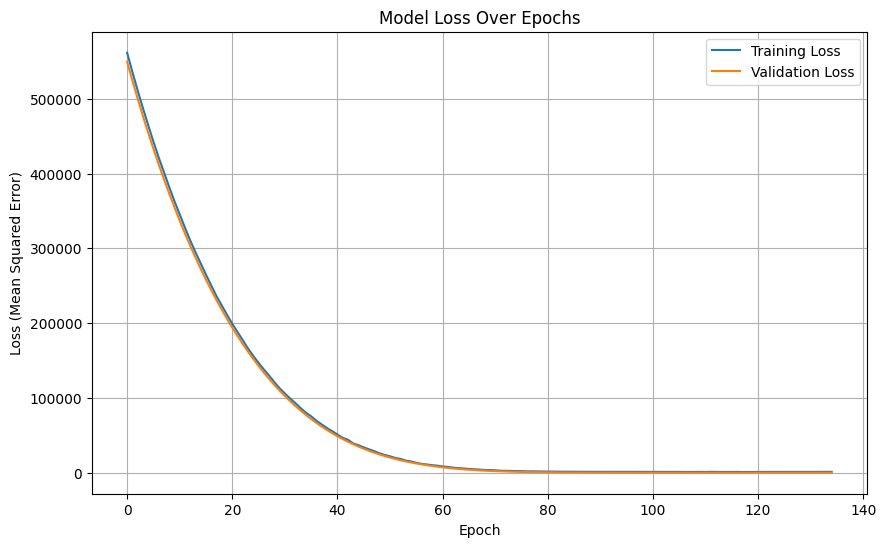

In [20]:
# --- Optional: Plotting Training History ---
# You can uncomment this section to visualize the training and validation loss.
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

## Visualize prediction results on validation dataset


--- Generating Predictions for Plotting ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


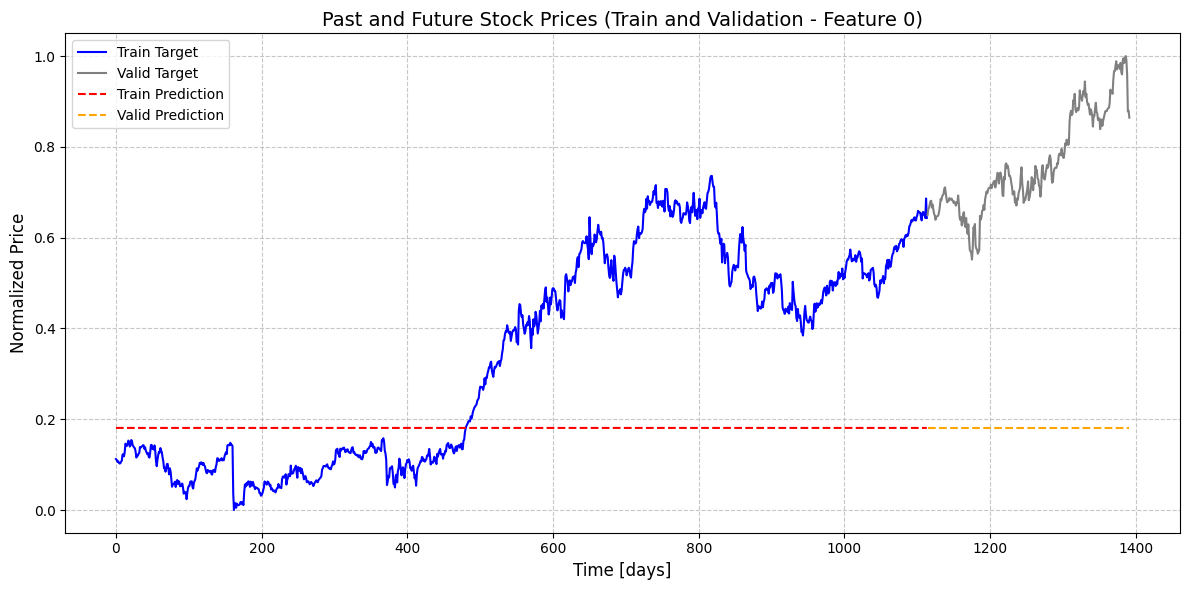


--- Correct Sign Prediction Correlation ---
Correct sign prediction for close - open price for train/valid/: 0.66/0.41



In [21]:
# --- Generate Predictions for Plotting ---
print("\n--- Generating Predictions for Plotting ---")

# Use model.predict() directly on the TensorFlow Tensors or NumPy arrays
y_train_pred_np = model.predict(x_train_tf)
y_valid_pred_np = model.predict(x_valid_tf)
y_test_pred_np = model.predict(x_test_tf)

# Convert actual TensorFlow Tensors to NumPy for plotting and calculations
y_train_actual_np = y_train_tf.numpy()
y_valid_actual_np = y_valid_tf.numpy()
y_test_actual_np = y_test_tf.numpy()


# --- Plotting Predictions vs. Actuals (Train and Validation Only) ---
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest (assuming these map to your features)

plt.figure(figsize=(12, 6)) # Adjusted overall figure size for a single plot

# Plot actual targets
plt.plot(np.arange(y_train_actual_np.shape[0]), y_train_actual_np[:,ft], color='blue', label='Train Target')
plt.plot(np.arange(y_train_actual_np.shape[0], y_train_actual_np.shape[0] + y_valid_actual_np.shape[0]),
         y_valid_actual_np[:,ft], color='gray', label='Valid Target')

# Plot predictions
plt.plot(np.arange(y_train_pred_np.shape[0]), y_train_pred_np[:,ft], color='red', label='Train Prediction', linestyle='--')
plt.plot(np.arange(y_train_pred_np.shape[0], y_train_pred_np.shape[0] + y_valid_pred_np.shape[0]),
         y_valid_pred_np[:,ft], color='orange', label='Valid Prediction', linestyle='--')

plt.title('Past and Future Stock Prices (Train and Validation - Feature 0)', fontsize=14)
plt.xlabel('Time [days]', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

# --- Calculate Correct Sign Prediction Correlation ---
print("\n--- Correct Sign Prediction Correlation ---")

# Ensure the target has at least two columns for difference calculation
if y_train_actual_np.shape[1] >= 2:
    corr_price_development_train = np.sum(np.equal(np.sign(y_train_actual_np[:,1]-y_train_actual_np[:,0]),
                                                    np.sign(y_train_pred_np[:,1]-y_train_pred_np[:,0])).astype(int)) / y_train_actual_np.shape[0]
else:
    corr_price_development_train = np.nan # Not applicable if only one feature

if y_valid_actual_np.shape[1] >= 2:
    corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_actual_np[:,1]-y_valid_actual_np[:,0]),
                                                    np.sign(y_valid_pred_np[:,1]-y_valid_pred_np[:,0])).astype(int)) / y_valid_actual_np.shape[0]
else:
    corr_price_development_valid = np.nan


print('Correct sign prediction for close - open price for train/valid/: %.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid))
print("="*40 + "\n")

## Model Architecture, model building, and model training (Simple RNN cell layer with TF custom layer)

In [22]:
# --- Custom TF Layer Definition ---
class CustomRNNBlock(layers.Layer):
    """
    A custom Keras layer that encapsulates Layer Normalization and a stack of SimpleRNN layers.
    This demonstrates how to combine multiple standard layers into a single custom layer.
    """
    def __init__(self, hidden_size, num_rnn_layers, dropout_rate, **kwargs):
        super(CustomRNNBlock, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_rnn_layers = num_rnn_layers
        self.dropout_rate = dropout_rate

        # Initialize Layer Normalization layer
        self.norm_layer = layers.LayerNormalization(axis=-1)

        # Initialize a list to hold stacked SimpleRNN layers
        self.rnn_layers = []
        for i in range(self.num_rnn_layers):
            # For all RNN layers except the very last one in this block,
            # 'return_sequences=True' to pass the sequence output to the next RNN.
            # For the last RNN layer in this block, 'return_sequences=False'
            # to output a single vector (the final hidden state).
            return_sequences = (i < self.num_rnn_layers - 1)
            self.rnn_layers.append(
                layers.SimpleRNN(
                    self.hidden_size,
                    return_sequences=return_sequences,
                    dropout=self.dropout_rate,
                    kernel_initializer='glorot_uniform',
                    recurrent_initializer='orthogonal'
                )
            )

    def call(self, inputs):
        """
        Defines the forward pass of the custom layer.
        """
        # Apply layer normalization to the input
        x = self.norm_layer(inputs)

        # Pass the output through each stacked RNN layer
        for rnn_layer in self.rnn_layers:
            x = rnn_layer(x)
        return x

    def get_config(self):
        """
        Required for saving and loading models that contain custom layers.
        """
        config = super(CustomRNNBlock, self).get_config()
        config.update({
            'hidden_size': self.hidden_size,
            'num_rnn_layers': self.num_rnn_layers,
            'dropout_rate': self.dropout_rate,
        })
        return config


# --- Define the RNN Model with Custom Layer ---
# Keras models are typically defined using the Sequential API.

# Model parameters
input_size = x_train_tf.shape[2] # Number of features at each time step
seq_len = x_train_tf.shape[1]    # Sequence length
hidden_size = 128                # Number of units in the RNN layers
num_layers = 3                   # Number of stacked RNN layers *within* the CustomRNNBlock
output_size = y_train_tf.shape[1] # Number of output features to predict
dropout_rate = 0.2               # Dropout rate for regularization

# Building the Sequential model using the custom CustomRNNBlock layer.
model = keras.Sequential([
    # Input Layer: Defines the expected shape of the input data.
    # The shape is (sequence_length, number_of_features_at_each_time_step).
    layers.Input(shape=(seq_len, input_size)),

    # CustomRNNBlock: Replaces the LayerNormalization and multiple SimpleRNN layers.
    # It encapsulates the logic for normalization and stacking RNNs.
    CustomRNNBlock(hidden_size=hidden_size, num_rnn_layers=num_layers, dropout_rate=dropout_rate),

    # Dropout Layer: Applied after the CustomRNNBlock's output.
    # This helps prevent overfitting.
    layers.Dropout(dropout_rate),

    # Dense (Fully Connected) Output Layer:
    # Maps the final RNN output to the desired prediction size.
    layers.Dense(output_size)
])


print(f"\n--- Keras RNN Model Architecture (with CustomRNNBlock) ---")
model.summary()
total_params = model.count_params()
print(f"Number of trainable parameters: {total_params}")
print("="*40 + "\n")

# --- Model Compilation (Loss function and optimizer) ---
# For time series regression, 'mse' (Mean Squared Error) is common.
# Adam optimizer is a popular choice for its efficiency.
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.MeanSquaredError())

# --- Training Loop with Early Stopping ---
num_epochs = 200 # Max epochs, early stopping will stop it sooner
patience = 8 # Number of epochs with no improvement after which training will be stopped

# Early Stopping callback:
# Monitors 'val_loss' (validation loss) and stops training if it doesn't improve
# for 'patience' number of epochs. It also restores the model weights from the
# epoch with the best validation loss.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

print("--- Starting Training with Early Stopping ---")
history = model.fit(
    x_train_tf, y_train_tf,
    epochs=num_epochs,
    validation_data=(x_valid_tf, y_valid_tf),
    callbacks=[early_stopping_callback],
    verbose=1 # Show training progress per epoch
)
print("\n--- Training Complete ---")
print("="*40 + "\n")


--- Keras RNN Model Architecture (with CustomRNNBlock) ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_rnn_block                │ (None, 128)            │        83,214 │
│ (CustomRNNBlock)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,117 (328.58 KB)

 Trainable params: 84,117 (328.58 KB)

 Non-trainable params: 0 (0.00 B)

Number of trainable parameters: 84117

--- Starting Training with Early Stopping ---
Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 567987.5000 - val_loss: 549408.4375
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 541617.1875 - val_loss: 524320.1250
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 516831.7188 - val_loss: 500260.0312
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 493181.6562 - val_loss: 477085.8750
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 469916.0000 - val_loss: 454731.3438
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 448013.8438 - val_loss: 433243.4062
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 426522.9062 - val_loss: 412540.9375
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 406109.1562 - val_loss: 392607.2188
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 386345.5312 - val_loss: 373408.1875
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/ste

## Plotting Training History

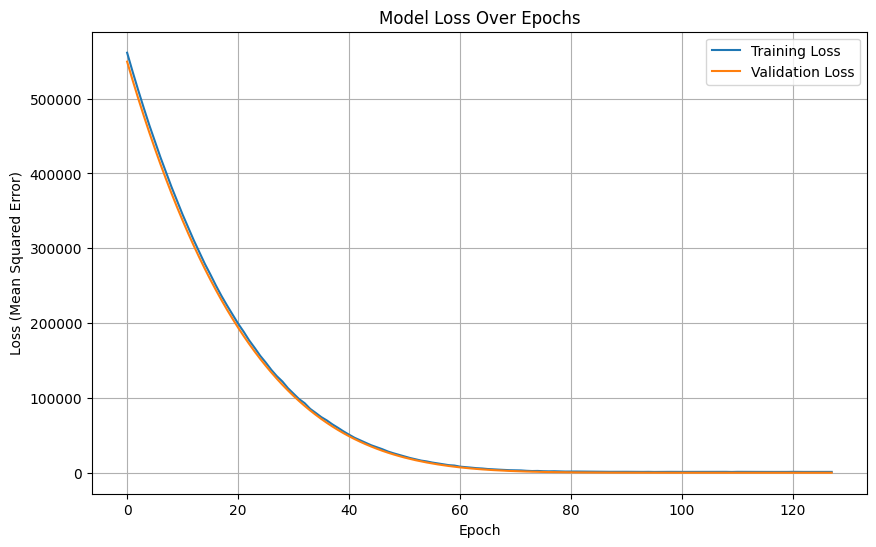

In [23]:
# --- Optional: Plotting Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

## Visualize prediction results on validation dataset


--- Generating Predictions for Plotting ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


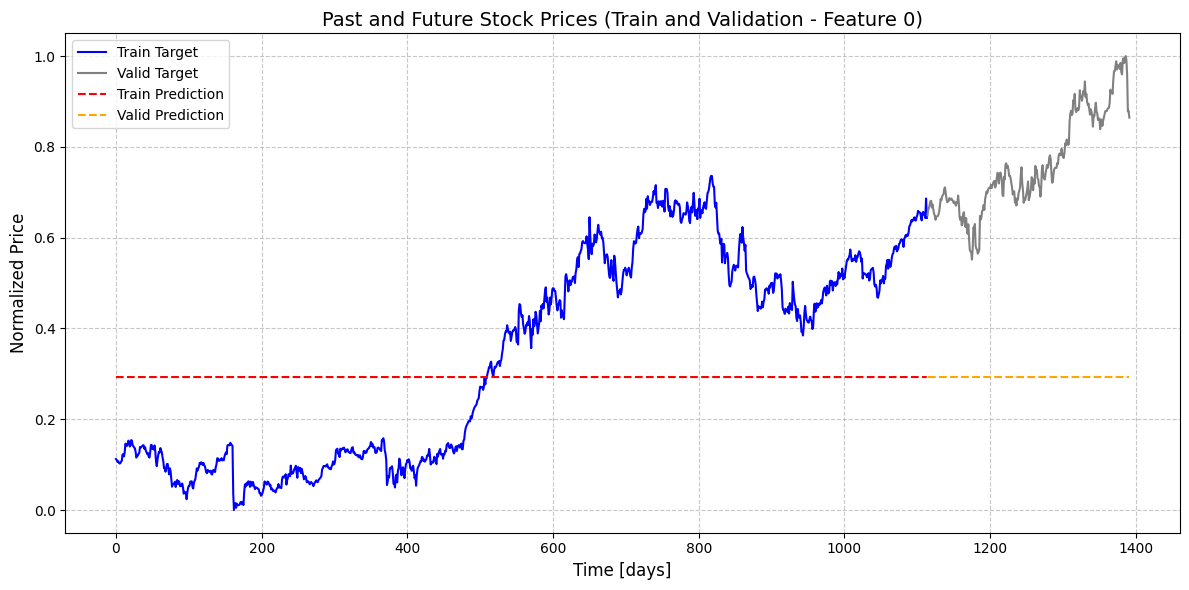


--- Correct Sign Prediction Correlation ---
Correct sign prediction for close - open price for train/valid/: 0.34/0.59



In [24]:
# --- Generate Predictions for Plotting ---
print("\n--- Generating Predictions for Plotting ---")

# Use model.predict() directly on the TensorFlow Tensors or NumPy arrays
y_train_pred_np = model.predict(x_train_tf)
y_valid_pred_np = model.predict(x_valid_tf)
y_test_pred_np = model.predict(x_test_tf)

# Convert actual TensorFlow Tensors to NumPy for plotting and calculations
y_train_actual_np = y_train_tf.numpy()
y_valid_actual_np = y_valid_tf.numpy()
y_test_actual_np = y_test_tf.numpy()


# --- Plotting Predictions vs. Actuals (Train and Validation Only) ---
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest (assuming these map to your features)

plt.figure(figsize=(12, 6)) # Adjusted overall figure size for a single plot

# Plot actual targets
plt.plot(np.arange(y_train_actual_np.shape[0]), y_train_actual_np[:,ft], color='blue', label='Train Target')
plt.plot(np.arange(y_train_actual_np.shape[0], y_train_actual_np.shape[0] + y_valid_actual_np.shape[0]),
         y_valid_actual_np[:,ft], color='gray', label='Valid Target')

# Plot predictions
plt.plot(np.arange(y_train_pred_np.shape[0]), y_train_pred_np[:,ft], color='red', label='Train Prediction', linestyle='--')
plt.plot(np.arange(y_train_pred_np.shape[0], y_train_pred_np.shape[0] + y_valid_pred_np.shape[0]),
         y_valid_pred_np[:,ft], color='orange', label='Valid Prediction', linestyle='--')

plt.title('Past and Future Stock Prices (Train and Validation - Feature 0)', fontsize=14)
plt.xlabel('Time [days]', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

# --- Calculate Correct Sign Prediction Correlation ---
print("\n--- Correct Sign Prediction Correlation ---")

# Ensure the target has at least two columns for difference calculation
if y_train_actual_np.shape[1] >= 2:
    corr_price_development_train = np.sum(np.equal(np.sign(y_train_actual_np[:,1]-y_train_actual_np[:,0]),
                                                    np.sign(y_train_pred_np[:,1]-y_train_pred_np[:,0])).astype(int)) / y_train_actual_np.shape[0]
else:
    corr_price_development_train = np.nan # Not applicable if only one feature

if y_valid_actual_np.shape[1] >= 2:
    corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_actual_np[:,1]-y_valid_actual_np[:,0]),
                                                    np.sign(y_valid_pred_np[:,1]-y_valid_pred_np[:,0])).astype(int)) / y_valid_actual_np.shape[0]
else:
    corr_price_development_valid = np.nan


print('Correct sign prediction for close - open price for train/valid/: %.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid))
print("="*40 + "\n")

## Model Architecture, model building, and model training (Base RNN layer with Keras)

In [25]:
# --- Define the RNN Model with Base RNN Layer ---
# Model parameters
input_size = x_train_tf.shape[2]  # Number of features at each time step
seq_len = x_train_tf.shape[1]     # Sequence length
hidden_size = 128                 # Number of units in the RNN layers
output_size = y_train_tf.shape[1] # Number of output features to predict
dropout_rate = 0.2                # Dropout rate for regularization
num_layers = 2                    # Number of RNN layers

# Define the model using Sequential API with RNN layer
model = keras.Sequential([
    # Input layer with specified shape
    layers.Input(shape=(seq_len, input_size)),
    
    # Layer Normalization
    layers.LayerNormalization(axis=-1),
    
    # Base RNN layer with stacked SimpleRNNCells
    layers.RNN(
        layers.SimpleRNNCell(hidden_size, dropout=dropout_rate),
        return_sequences=True,
        return_state=False
    ),
    layers.RNN(
        layers.SimpleRNNCell(hidden_size, dropout=dropout_rate),
        return_sequences=False,
        return_state=False
    ),
    
    # Dropout layer after the last RNN layer
    layers.Dropout(dropout_rate),
    
    # Dense output layer
    layers.Dense(output_size)
])

print(f"\n--- Keras RNN Model Architecture ---")
model.summary()
total_params = model.count_params()
print(f"Number of trainable parameters: {total_params}")
print("="*40 + "\n")

# --- Model Compilation ---
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.MeanSquaredError()
)

# --- Training Loop with Early Stopping ---
num_epochs = 200
patience = 8

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

print("--- Starting Training with Early Stopping ---")
history = model.fit(
    x_train_tf, y_train_tf,
    epochs=num_epochs,
    validation_data=(x_valid_tf, y_valid_tf),
    callbacks=[early_stopping_callback],
    verbose=1
)
print("\n--- Training Complete ---")
print("="*40 + "\n")


--- Keras RNN Model Architecture ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_normalization_2           │ (None, 30, 7)          │            14 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (RNN)                       │ (None, 30, 128)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (RNN)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,221 (200.08 KB)

 Trainable params: 51,221 (200.08 KB)

 Non-trainable params: 0 (0.00 B)

Number of trainable parameters: 51221

--- Starting Training with Early Stopping ---
Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 568503.2500 - val_loss: 549878.3125
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 542007.0625 - val_loss: 524694.1250
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 517158.6250 - val_loss: 500559.7188
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 493147.5000 - val_loss: 477339.6250
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 470376.1250 - val_loss: 455023.7500
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 447950.8750 - val_loss: 433522.2812
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 426964.7812 - val_loss: 412818.4688
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 406327.8125 - val_loss: 392873.3750
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 386834.3750 - val_loss: 373678.7812
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/ste

## Plotting Training History

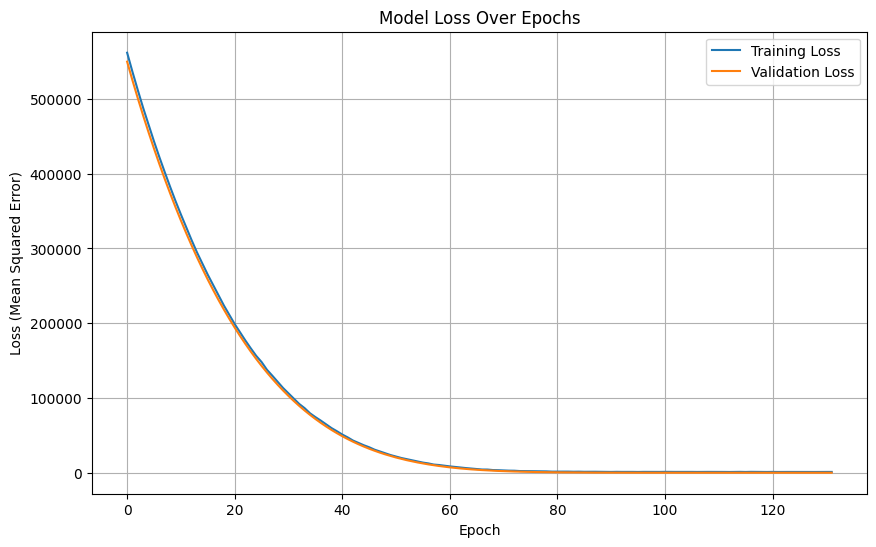

In [26]:
# --- Optional: Plotting Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

## Visualize prediction results on validation dataset


--- Generating Predictions for Plotting ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


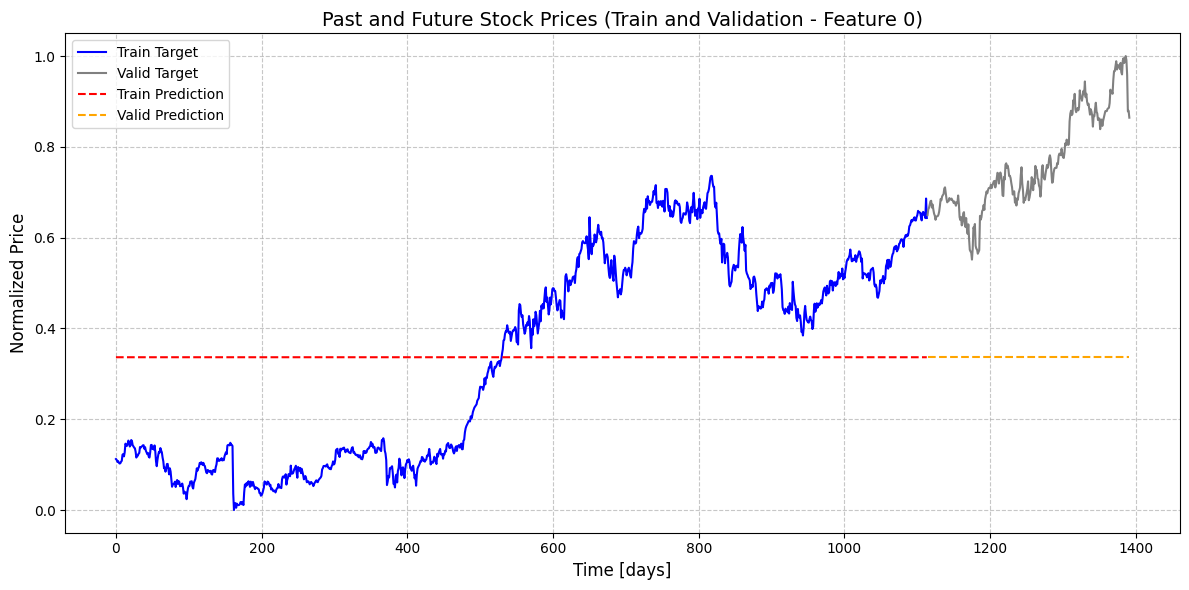


--- Correct Sign Prediction Correlation ---
Correct sign prediction for close - open price for train/valid/: 0.66/0.41



In [27]:
# --- Generate Predictions for Plotting ---
print("\n--- Generating Predictions for Plotting ---")

# Use model.predict() directly on the TensorFlow Tensors or NumPy arrays
y_train_pred_np = model.predict(x_train_tf)
y_valid_pred_np = model.predict(x_valid_tf)
y_test_pred_np = model.predict(x_test_tf)

# Convert actual TensorFlow Tensors to NumPy for plotting and calculations
y_train_actual_np = y_train_tf.numpy()
y_valid_actual_np = y_valid_tf.numpy()
y_test_actual_np = y_test_tf.numpy()


# --- Plotting Predictions vs. Actuals (Train and Validation Only) ---
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest (assuming these map to your features)

plt.figure(figsize=(12, 6)) # Adjusted overall figure size for a single plot

# Plot actual targets
plt.plot(np.arange(y_train_actual_np.shape[0]), y_train_actual_np[:,ft], color='blue', label='Train Target')
plt.plot(np.arange(y_train_actual_np.shape[0], y_train_actual_np.shape[0] + y_valid_actual_np.shape[0]),
         y_valid_actual_np[:,ft], color='gray', label='Valid Target')

# Plot predictions
plt.plot(np.arange(y_train_pred_np.shape[0]), y_train_pred_np[:,ft], color='red', label='Train Prediction', linestyle='--')
plt.plot(np.arange(y_train_pred_np.shape[0], y_train_pred_np.shape[0] + y_valid_pred_np.shape[0]),
         y_valid_pred_np[:,ft], color='orange', label='Valid Prediction', linestyle='--')

plt.title('Past and Future Stock Prices (Train and Validation - Feature 0)', fontsize=14)
plt.xlabel('Time [days]', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

# --- Calculate Correct Sign Prediction Correlation ---
print("\n--- Correct Sign Prediction Correlation ---")

# Ensure the target has at least two columns for difference calculation
if y_train_actual_np.shape[1] >= 2:
    corr_price_development_train = np.sum(np.equal(np.sign(y_train_actual_np[:,1]-y_train_actual_np[:,0]),
                                                    np.sign(y_train_pred_np[:,1]-y_train_pred_np[:,0])).astype(int)) / y_train_actual_np.shape[0]
else:
    corr_price_development_train = np.nan # Not applicable if only one feature

if y_valid_actual_np.shape[1] >= 2:
    corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_actual_np[:,1]-y_valid_actual_np[:,0]),
                                                    np.sign(y_valid_pred_np[:,1]-y_valid_pred_np[:,0])).astype(int)) / y_valid_actual_np.shape[0]
else:
    corr_price_development_valid = np.nan


print('Correct sign prediction for close - open price for train/valid/: %.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid))
print("="*40 + "\n")

## Model Architecture, model building, and model training (Base RNN layer with TF custom layer)

In [28]:
# --- Custom Keras Layer Definition ---
class CustomRNNStack(layers.Layer):
    """
    A custom Keras layer that encapsulates Layer Normalization and a stack of
    layers.RNN, each wrapping a SimpleRNNCell.
    This demonstrates how to combine multiple standard layers into a single custom layer.
    """
    def __init__(self, hidden_size, num_rnn_layers, dropout_rate, **kwargs):
        super(CustomRNNStack, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_rnn_layers = num_rnn_layers
        self.dropout_rate = dropout_rate

        # Initialize Layer Normalization layer
        self.norm_layer = layers.LayerNormalization(axis=-1)

        # Initialize a list to hold stacked RNN layers (each wrapping a SimpleRNNCell)
        self.rnn_layers = []
        for i in range(self.num_rnn_layers):
            # For all RNN layers except the very last one in this block,
            # 'return_sequences=True' to pass the sequence output to the next RNN.
            # For the last RNN layer in this block, 'return_sequences=False'
            # to output a single vector (the final hidden state).
            return_sequences = (i < self.num_rnn_layers - 1)
            self.rnn_layers.append(
                layers.RNN(
                    layers.SimpleRNNCell(
                        self.hidden_size,
                        dropout=self.dropout_rate,          # Dropout applied to the input of each RNN cell
                        recurrent_dropout=self.dropout_rate, # Dropout applied to the recurrent state
                        kernel_initializer='glorot_uniform',
                        recurrent_initializer='orthogonal'
                    ),
                    return_sequences=return_sequences,
                    name=f'rnn_layer_{i+1}' # Give names for easier access for plotting
                )
            )

    def call(self, inputs):
        """
        Defines the forward pass of the custom layer.
        """
        # Apply layer normalization to the input
        x = self.norm_layer(inputs)

        # Pass the output through each stacked RNN layer
        for rnn_layer in self.rnn_layers:
            x = rnn_layer(x)
        return x

    def get_config(self):
        """
        Required for saving and loading models that contain custom layers.
        """
        config = super(CustomRNNStack, self).get_config()
        config.update({
            'hidden_size': self.hidden_size,
            'num_rnn_layers': self.num_rnn_layers,
            'dropout_rate': self.dropout_rate,
        })
        return config


# --- Define the RNN Model with Custom Layer (using CustomRNNStack) ---
# Keras models are typically defined using the Sequential API.

# Model parameters
input_size = x_train_tf.shape[2] # Number of features at each time step
seq_len = x_train_tf.shape[1]    # Sequence length
hidden_size = 128                # Number of units in the RNN layers
num_layers = 3                   # Number of stacked RNN layers *within* the CustomRNNStack
output_size = y_train_tf.shape[1] # Number of output features to predict
dropout_rate = 0.2               # Dropout rate for regularization

# Building the Sequential model using the custom CustomRNNStack layer.
model = keras.Sequential([
    # Input Layer: Defines the expected shape of the input data.
    # The shape is (sequence_length, number_of_features_at_each_time_step).
    layers.Input(shape=(seq_len, input_size)),

    # CustomRNNStack: Encapsulates LayerNormalization and multiple RNN layers.
    CustomRNNStack(hidden_size=hidden_size, num_rnn_layers=num_layers, dropout_rate=dropout_rate),

    # Dropout Layer: Applied after the CustomRNNStack's output.
    # This helps prevent overfitting.
    layers.Dropout(dropout_rate),

    # Dense (Fully Connected) Output Layer:
    # Maps the final RNN output to the desired prediction size.
    layers.Dense(output_size)
])


print(f"\n--- Keras RNN Model Architecture (with CustomRNNStack) ---")
model.summary()
total_params = model.count_params()
print(f"Number of trainable parameters: {total_params}")
print("="*40 + "\n")

# --- Model Compilation (Loss function and optimizer) ---
# For time series regression, 'mse' (Mean Squared Error) is common.
# Adam optimizer is a popular choice for its efficiency.
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.MeanSquaredError())

# --- Training Loop with Early Stopping ---
num_epochs = 200 # Max epochs, early stopping will stop it sooner
patience = 8 # Number of epochs with no improvement after which training will be stopped

# Early Stopping callback:
# Monitors 'val_loss' (validation loss) and stops training if it doesn't improve
# for 'patience' number of epochs. It also restores the model weights from the
# epoch with the best validation loss.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

print("--- Starting Training with Early Stopping ---")
history = model.fit(
    x_train_tf, y_train_tf,
    epochs=num_epochs,
    validation_data=(x_valid_tf, y_valid_tf),
    callbacks=[early_stopping_callback],
    verbose=1 # Show training progress per epoch
)
print("\n--- Training Complete ---")
print("="*40 + "\n")


--- Keras RNN Model Architecture (with CustomRNNStack) ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_rnn_stack                │ (None, 128)            │        83,214 │
│ (CustomRNNStack)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,117 (328.58 KB)

 Trainable params: 84,117 (328.58 KB)

 Non-trainable params: 0 (0.00 B)

Number of trainable parameters: 84117

--- Starting Training with Early Stopping ---
Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 567280.3125 - val_loss: 548289.2500
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 540456.7500 - val_loss: 523131.9062
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 515533.8125 - val_loss: 499040.0000
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 491832.0312 - val_loss: 475905.5625
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 468927.8125 - val_loss: 453612.0000
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 446780.3438 - val_loss: 432124.0312
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 425481.5625 - val_loss: 411430.5000
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 404803.2812 - val_loss: 391482.3750
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 385225.5312 - val_loss: 372277.6250
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/st

## Plotting Training History

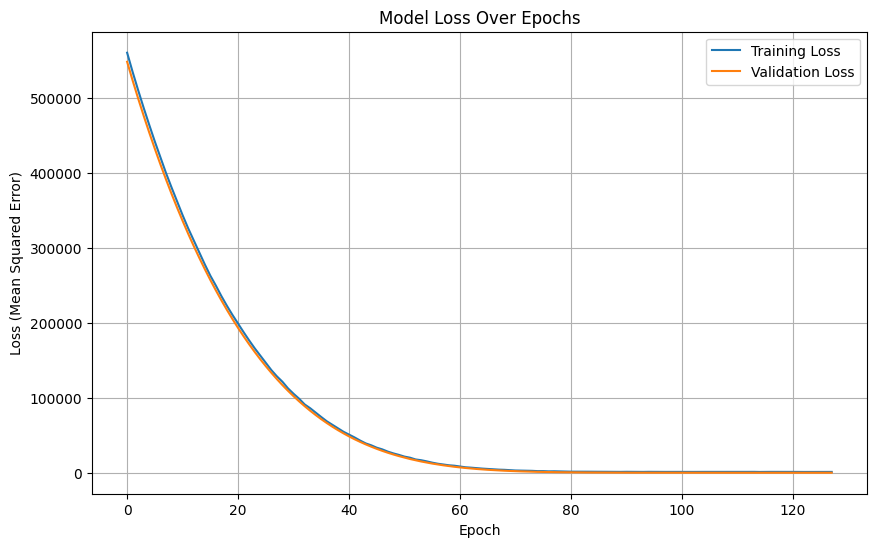

In [29]:
# --- Optional: Plotting Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

## Visualize prediction results on validation dataset


--- Generating Predictions for Plotting ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


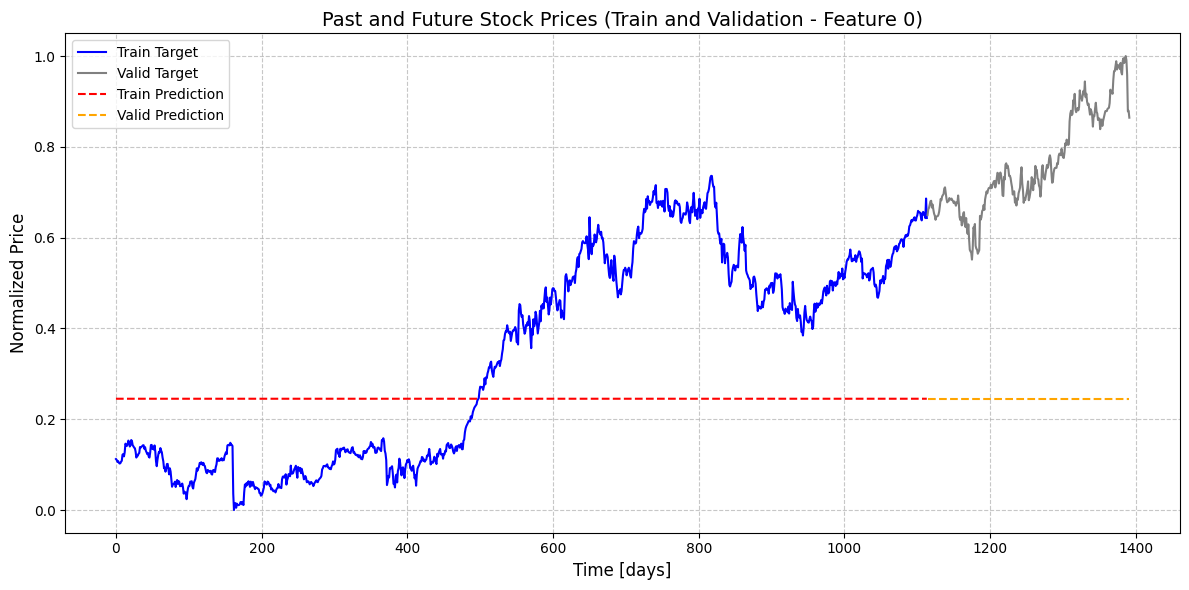


--- Correct Sign Prediction Correlation ---
Correct sign prediction for close - open price for train/valid/: 0.66/0.41



In [30]:
# --- Generate Predictions for Plotting ---
print("\n--- Generating Predictions for Plotting ---")

# Use model.predict() directly on the TensorFlow Tensors or NumPy arrays
y_train_pred_np = model.predict(x_train_tf)
y_valid_pred_np = model.predict(x_valid_tf)
y_test_pred_np = model.predict(x_test_tf)

# Convert actual TensorFlow Tensors to NumPy for plotting and calculations
y_train_actual_np = y_train_tf.numpy()
y_valid_actual_np = y_valid_tf.numpy()
y_test_actual_np = y_test_tf.numpy()


# --- Plotting Predictions vs. Actuals (Train and Validation Only) ---
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest (assuming these map to your features)

plt.figure(figsize=(12, 6)) # Adjusted overall figure size for a single plot

# Plot actual targets
plt.plot(np.arange(y_train_actual_np.shape[0]), y_train_actual_np[:,ft], color='blue', label='Train Target')
plt.plot(np.arange(y_train_actual_np.shape[0], y_train_actual_np.shape[0] + y_valid_actual_np.shape[0]),
         y_valid_actual_np[:,ft], color='gray', label='Valid Target')

# Plot predictions
plt.plot(np.arange(y_train_pred_np.shape[0]), y_train_pred_np[:,ft], color='red', label='Train Prediction', linestyle='--')
plt.plot(np.arange(y_train_pred_np.shape[0], y_train_pred_np.shape[0] + y_valid_pred_np.shape[0]),
         y_valid_pred_np[:,ft], color='orange', label='Valid Prediction', linestyle='--')

plt.title('Past and Future Stock Prices (Train and Validation - Feature 0)', fontsize=14)
plt.xlabel('Time [days]', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

# --- Calculate Correct Sign Prediction Correlation ---
print("\n--- Correct Sign Prediction Correlation ---")

# Ensure the target has at least two columns for difference calculation
if y_train_actual_np.shape[1] >= 2:
    corr_price_development_train = np.sum(np.equal(np.sign(y_train_actual_np[:,1]-y_train_actual_np[:,0]),
                                                    np.sign(y_train_pred_np[:,1]-y_train_pred_np[:,0])).astype(int)) / y_train_actual_np.shape[0]
else:
    corr_price_development_train = np.nan # Not applicable if only one feature

if y_valid_actual_np.shape[1] >= 2:
    corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_actual_np[:,1]-y_valid_actual_np[:,0]),
                                                    np.sign(y_valid_pred_np[:,1]-y_valid_pred_np[:,0])).astype(int)) / y_valid_actual_np.shape[0]
else:
    corr_price_development_valid = np.nan


print('Correct sign prediction for close - open price for train/valid/: %.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid))
print("="*40 + "\n")

## Model Architecture, model building, and model training (Stacked RNN cell layer with Keras)

In [31]:
# --- Define the RNN Model with Stacked RNN Layer ---
# Model parameters
input_size = x_train_tf.shape[2]  # Number of features at each time step
seq_len = x_train_tf.shape[1]     # Sequence length
hidden_size = 128                 # Number of units in the RNN layers
output_size = y_train_tf.shape[1] # Number of output features to predict
dropout_rate = 0.2                # Dropout rate for regularization
num_layers = 2                    # Number of RNN layers

# Create a list of SimpleRNNCell instances for stacking
rnn_cells = [layers.SimpleRNNCell(hidden_size, dropout=dropout_rate) for _ in range(num_layers - 1)]
rnn_cells.append(layers.SimpleRNNCell(hidden_size, dropout=dropout_rate))  # Last layer

# Define the model using Sequential API with StackedRNNCells
model = keras.Sequential([
    # Input layer with specified shape
    layers.Input(shape=(seq_len, input_size)),
    
    # Layer Normalization
    layers.LayerNormalization(axis=-1),
    
    # Stacked RNN layer with multiple SimpleRNNCells
    layers.RNN(
        layers.StackedRNNCells(rnn_cells),
        return_sequences=False,  # Final output is the last time step
        return_state=False
    ),
    
    # Dropout layer after the stacked RNN
    layers.Dropout(dropout_rate),
    
    # Dense output layer
    layers.Dense(output_size)
])

print(f"\n--- Keras RNN Model Architecture ---")
model.summary()
total_params = model.count_params()
print(f"Number of trainable parameters: {total_params}")
print("="*40 + "\n")

# --- Model Compilation ---
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.MeanSquaredError()
)

# --- Training Loop with Early Stopping ---
num_epochs = 200
patience = 8

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

print("--- Starting Training with Early Stopping ---")
history = model.fit(
    x_train_tf, y_train_tf,
    epochs=num_epochs,
    validation_data=(x_valid_tf, y_valid_tf),
    callbacks=[early_stopping_callback],
    verbose=1
)
print("\n--- Training Complete ---")
print("="*40 + "\n")


--- Keras RNN Model Architecture ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_normalization_4           │ (None, 30, 7)          │            14 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_2 (RNN)                     │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,221 (200.08 KB)

 Trainable params: 51,221 (200.08 KB)

 Non-trainable params: 0 (0.00 B)

Number of trainable parameters: 51221

--- Starting Training with Early Stopping ---
Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 567392.7500 - val_loss: 548972.4375
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 541112.6875 - val_loss: 523986.2500
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 516401.1250 - val_loss: 499964.5312
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 492636.5938 - val_loss: 476871.8438
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 469758.0625 - val_loss: 454605.6250
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 447675.0938 - val_loss: 433145.7500
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 426562.4688 - val_loss: 412480.4688
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 405950.8750 - val_loss: 392585.2812
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 386239.7812 - val_loss: 373394.7500
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/ste

## Plotting Training History

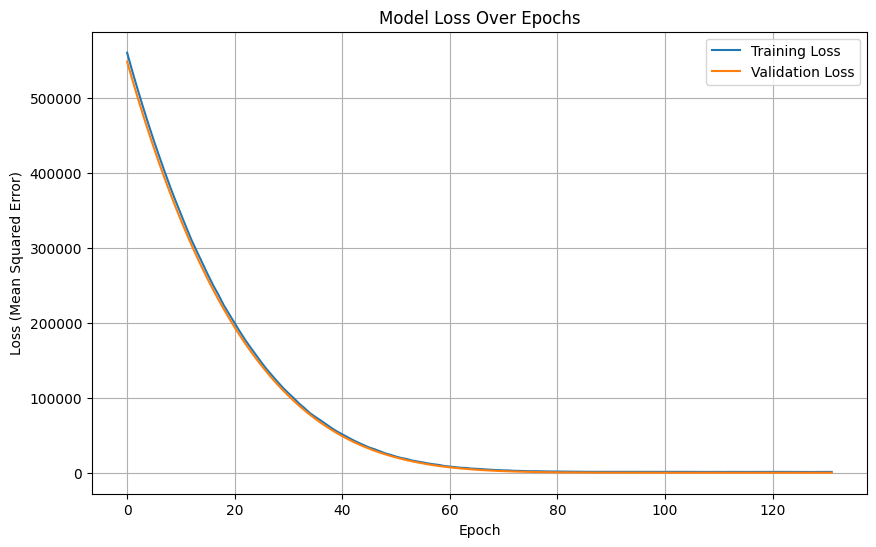

In [32]:
# --- Optional: Plotting Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

## Visualize prediction results on validation dataset


--- Generating Predictions for Plotting ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


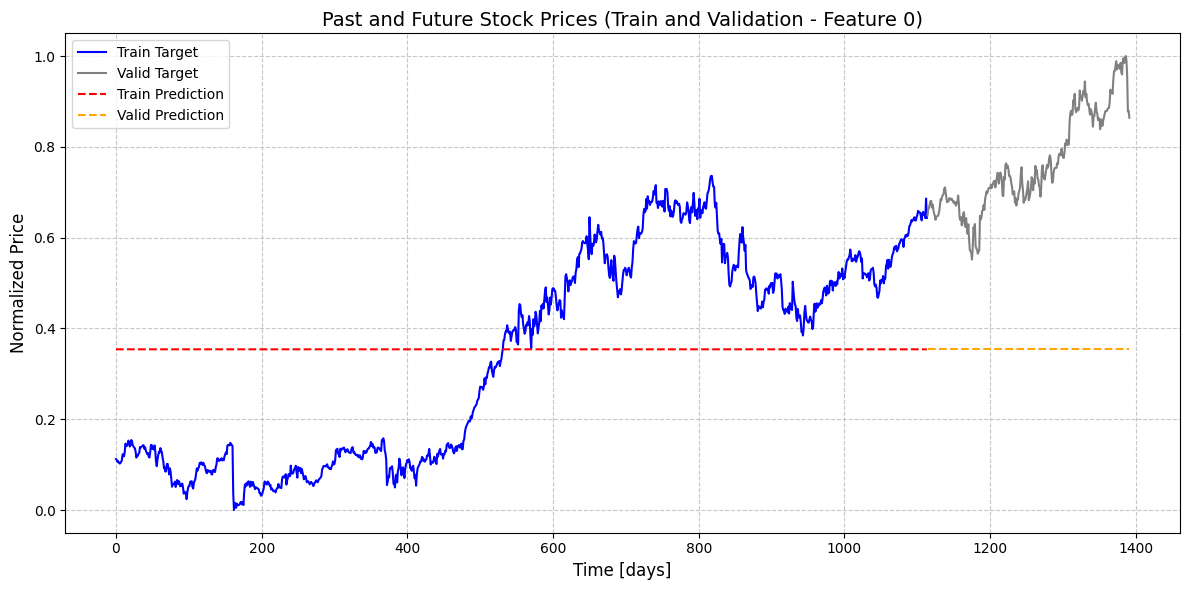


--- Correct Sign Prediction Correlation ---
Correct sign prediction for close - open price for train/valid/: 0.66/0.41



In [33]:
# --- Generate Predictions for Plotting ---
print("\n--- Generating Predictions for Plotting ---")

# Use model.predict() directly on the TensorFlow Tensors or NumPy arrays
y_train_pred_np = model.predict(x_train_tf)
y_valid_pred_np = model.predict(x_valid_tf)
y_test_pred_np = model.predict(x_test_tf)

# Convert actual TensorFlow Tensors to NumPy for plotting and calculations
y_train_actual_np = y_train_tf.numpy()
y_valid_actual_np = y_valid_tf.numpy()
y_test_actual_np = y_test_tf.numpy()


# --- Plotting Predictions vs. Actuals (Train and Validation Only) ---
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest (assuming these map to your features)

plt.figure(figsize=(12, 6)) # Adjusted overall figure size for a single plot

# Plot actual targets
plt.plot(np.arange(y_train_actual_np.shape[0]), y_train_actual_np[:,ft], color='blue', label='Train Target')
plt.plot(np.arange(y_train_actual_np.shape[0], y_train_actual_np.shape[0] + y_valid_actual_np.shape[0]),
         y_valid_actual_np[:,ft], color='gray', label='Valid Target')

# Plot predictions
plt.plot(np.arange(y_train_pred_np.shape[0]), y_train_pred_np[:,ft], color='red', label='Train Prediction', linestyle='--')
plt.plot(np.arange(y_train_pred_np.shape[0], y_train_pred_np.shape[0] + y_valid_pred_np.shape[0]),
         y_valid_pred_np[:,ft], color='orange', label='Valid Prediction', linestyle='--')

plt.title('Past and Future Stock Prices (Train and Validation - Feature 0)', fontsize=14)
plt.xlabel('Time [days]', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

# --- Calculate Correct Sign Prediction Correlation ---
print("\n--- Correct Sign Prediction Correlation ---")

# Ensure the target has at least two columns for difference calculation
if y_train_actual_np.shape[1] >= 2:
    corr_price_development_train = np.sum(np.equal(np.sign(y_train_actual_np[:,1]-y_train_actual_np[:,0]),
                                                    np.sign(y_train_pred_np[:,1]-y_train_pred_np[:,0])).astype(int)) / y_train_actual_np.shape[0]
else:
    corr_price_development_train = np.nan # Not applicable if only one feature

if y_valid_actual_np.shape[1] >= 2:
    corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_actual_np[:,1]-y_valid_actual_np[:,0]),
                                                    np.sign(y_valid_pred_np[:,1]-y_valid_pred_np[:,0])).astype(int)) / y_valid_actual_np.shape[0]
else:
    corr_price_development_valid = np.nan


print('Correct sign prediction for close - open price for train/valid/: %.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid))
print("="*40 + "\n")

## Model Architecture, model building, and model training (Stacked RNN cell layer with TF custom layer)

In [34]:
# --- Custom Keras Layer Definition ---
class CustomRNNStack(layers.Layer):
    """
    A custom Keras layer that encapsulates Layer Normalization and a single
    layers.RNN layer wrapping multiple SimpleRNNCells (StackedRNNCells).
    This allows for a stacked RNN architecture within a single custom layer.
    """
    def __init__(self, hidden_size, num_rnn_layers, dropout_rate, return_sequences_overall=False, **kwargs):
        super(CustomRNNStack, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_rnn_layers = num_rnn_layers
        self.dropout_rate = dropout_rate
        self.return_sequences_overall = return_sequences_overall # Whether the overall custom layer returns sequences

        # Initialize Layer Normalization layer
        self.norm_layer = layers.LayerNormalization(axis=-1)

        # Create a list of SimpleRNNCell instances
        rnn_cells = []
        for _ in range(self.num_rnn_layers):
            rnn_cells.append(
                layers.SimpleRNNCell(
                    self.hidden_size,
                    dropout=self.dropout_rate,          # Dropout applied to the input of each RNN cell
                    recurrent_dropout=self.dropout_rate, # Dropout applied to the recurrent state
                    kernel_initializer='glorot_uniform',
                    recurrent_initializer='orthogonal'
                )
            )
        # Wrap the list of cells in StackedRNNCells
        self.stacked_cells = layers.StackedRNNCells(rnn_cells)

        # Create a single RNN layer that uses the stacked cells.
        # This internal RNN layer will *always* return sequences so that
        # its activations over time can be extracted for plotting.
        self.stacked_rnn_layer = layers.RNN(
            self.stacked_cells,
            return_sequences=True, # Essential for extracting sequence of hidden states for plotting
            name='stacked_rnn_output_for_plotting' # Give it a name for easy access in plotting
        )

    def call(self, inputs):
        """
        Defines the forward pass of the custom layer.
        """
        # Apply layer normalization to the input
        x = self.norm_layer(inputs)

        # Pass the output through the stacked RNN layer
        # The output 'x' here will be (batch_size, seq_len, hidden_size)
        x = self.stacked_rnn_layer(x)

        # If the overall custom layer is not meant to return sequences,
        # take only the last time step's output.
        if not self.return_sequences_overall:
            x = x[:, -1, :] # Take the hidden state from the last time step
        return x

    def get_config(self):
        """
        Required for saving and loading models that contain custom layers.
        """
        config = super(CustomRNNStack, self).get_config()
        config.update({
            'hidden_size': self.hidden_size,
            'num_rnn_layers': self.num_rnn_layers,
            'dropout_rate': self.dropout_rate,
            'return_sequences_overall': self.return_sequences_overall,
        })
        return config


# --- Define the RNN Model with Custom Layer (using CustomRNNStack) ---
# Keras models are typically defined using the Sequential API.

# Model parameters
input_size = x_train_tf.shape[2] # Number of features at each time step
seq_len = x_train_tf.shape[1]    # Sequence length
hidden_size = 128                # Number of units in the RNN layers
num_layers = 3                   # Number of stacked RNN layers *within* the CustomRNNStack
output_size = y_train_tf.shape[1] # Number of output features to predict
dropout_rate = 0.2               # Dropout rate for regularization

# Building the Sequential model using the custom CustomRNNStack layer.
model = keras.Sequential([
    # Input Layer: Defines the expected shape of the input data.
    # The shape is (sequence_length, number_of_features_at_each_time_step).
    layers.Input(shape=(seq_len, input_size)),

    # CustomRNNStack: Encapsulates LayerNormalization and multiple RNN layers.
    # Set return_sequences_overall=False as this is the last recurrent block before Dense.
    CustomRNNStack(hidden_size=hidden_size, num_rnn_layers=num_layers, dropout_rate=dropout_rate, return_sequences_overall=False),

    # Dropout Layer: Applied after the CustomRNNStack's output (which is now a single vector).
    # This helps prevent overfitting.
    layers.Dropout(dropout_rate),

    # Dense (Fully Connected) Output Layer:
    # Maps the final RNN output to the desired prediction size.
    layers.Dense(output_size)
])


print(f"\n--- Keras RNN Model Architecture (with CustomRNNStack) ---")
model.summary()
total_params = model.count_params()
print(f"Number of trainable parameters: {total_params}")
print("="*40 + "\n")

# --- Model Compilation (Loss function and optimizer) ---
# For time series regression, 'mse' (Mean Squared Error) is common.
# Adam optimizer is a popular choice for its efficiency.
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.MeanSquaredError())

# --- Training Loop with Early Stopping ---
num_epochs = 200 # Max epochs, early stopping will stop it sooner
patience = 8 # Number of epochs with no improvement after which training will be stopped

# Early Stopping callback:
# Monitors 'val_loss' (validation loss) and stops training if it doesn't improve
# for 'patience' number of epochs. It also restores the model weights from the
# epoch with the best validation loss.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

print("--- Starting Training with Early Stopping ---")
history = model.fit(
    x_train_tf, y_train_tf,
    epochs=num_epochs,
    validation_data=(x_valid_tf, y_valid_tf),
    callbacks=[early_stopping_callback],
    verbose=1 # Show training progress per epoch
)
print("\n--- Training Complete ---")
print("="*40 + "\n")


--- Keras RNN Model Architecture (with CustomRNNStack) ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_rnn_stack_1              │ (None, 128)            │        83,214 │
│ (CustomRNNStack)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,117 (328.58 KB)

 Trainable params: 84,117 (328.58 KB)

 Non-trainable params: 0 (0.00 B)

Number of trainable parameters: 84117

--- Starting Training with Early Stopping ---
Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 568032.0625 - val_loss: 549226.6875
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 541418.3750 - val_loss: 524006.7188
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 516470.6875 - val_loss: 499868.0312
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 492342.8438 - val_loss: 476640.2812
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 469528.4062 - val_loss: 454301.2812
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 447909.0312 - val_loss: 432813.9062
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 429547.8125 - val_loss: 412216.4375
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 406432.0000 - val_loss: 392272.1562
Epoch 9/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 386438.2188 - val_loss: 373058.4375
Epoch 10/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/ste

## Plotting Training History

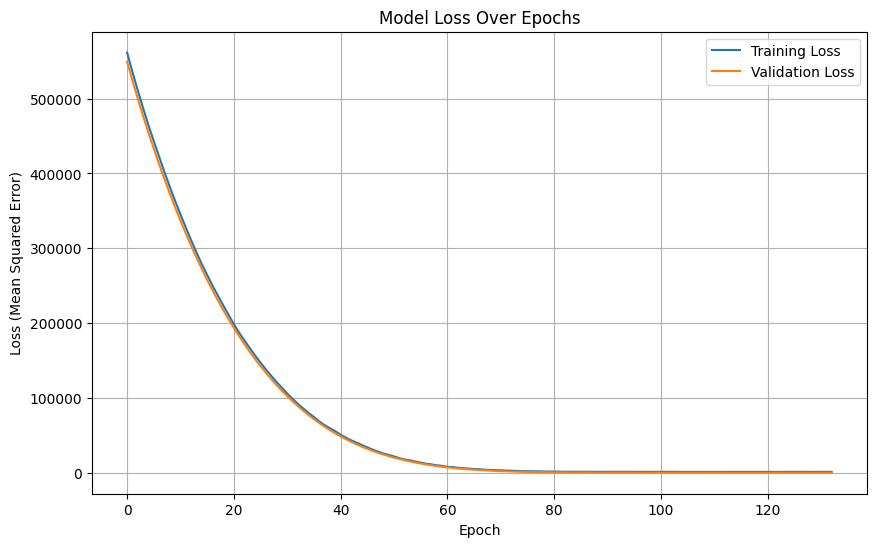

In [35]:
# --- Optional: Plotting Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

## Visualize prediction results on validation dataset


--- Generating Predictions for Plotting ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


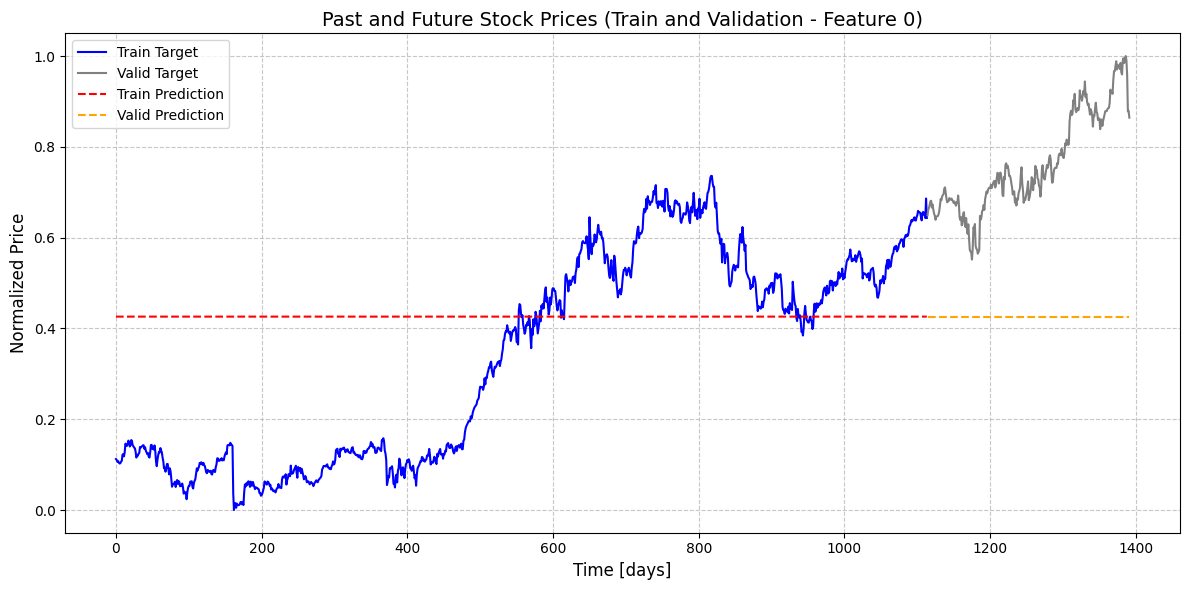


--- Correct Sign Prediction Correlation ---
Correct sign prediction for close - open price for train/valid/: 0.34/0.59



In [36]:
# --- Generate Predictions for Plotting ---
print("\n--- Generating Predictions for Plotting ---")

# Use model.predict() directly on the TensorFlow Tensors or NumPy arrays
y_train_pred_np = model.predict(x_train_tf)
y_valid_pred_np = model.predict(x_valid_tf)
y_test_pred_np = model.predict(x_test_tf)

# Convert actual TensorFlow Tensors to NumPy for plotting and calculations
y_train_actual_np = y_train_tf.numpy()
y_valid_actual_np = y_valid_tf.numpy()
y_test_actual_np = y_test_tf.numpy()


# --- Plotting Predictions vs. Actuals (Train and Validation Only) ---
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest (assuming these map to your features)

plt.figure(figsize=(12, 6)) # Adjusted overall figure size for a single plot

# Plot actual targets
plt.plot(np.arange(y_train_actual_np.shape[0]), y_train_actual_np[:,ft], color='blue', label='Train Target')
plt.plot(np.arange(y_train_actual_np.shape[0], y_train_actual_np.shape[0] + y_valid_actual_np.shape[0]),
         y_valid_actual_np[:,ft], color='gray', label='Valid Target')

# Plot predictions
plt.plot(np.arange(y_train_pred_np.shape[0]), y_train_pred_np[:,ft], color='red', label='Train Prediction', linestyle='--')
plt.plot(np.arange(y_train_pred_np.shape[0], y_train_pred_np.shape[0] + y_valid_pred_np.shape[0]),
         y_valid_pred_np[:,ft], color='orange', label='Valid Prediction', linestyle='--')

plt.title('Past and Future Stock Prices (Train and Validation - Feature 0)', fontsize=14)
plt.xlabel('Time [days]', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

# --- Calculate Correct Sign Prediction Correlation ---
print("\n--- Correct Sign Prediction Correlation ---")

# Ensure the target has at least two columns for difference calculation
if y_train_actual_np.shape[1] >= 2:
    corr_price_development_train = np.sum(np.equal(np.sign(y_train_actual_np[:,1]-y_train_actual_np[:,0]),
                                                    np.sign(y_train_pred_np[:,1]-y_train_pred_np[:,0])).astype(int)) / y_train_actual_np.shape[0]
else:
    corr_price_development_train = np.nan # Not applicable if only one feature

if y_valid_actual_np.shape[1] >= 2:
    corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_actual_np[:,1]-y_valid_actual_np[:,0]),
                                                    np.sign(y_valid_pred_np[:,1]-y_valid_pred_np[:,0])).astype(int)) / y_valid_actual_np.shape[0]
else:
    corr_price_development_valid = np.nan


print('Correct sign prediction for close - open price for train/valid/: %.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid))
print("="*40 + "\n")

# Model Evaluation

## Evaluate model on accuracy metrics for regression (MSE)

In [37]:
# --- Final Test Evaluation ---
print("\n--- Final Test Evaluation ---")
# In Keras, you use model.evaluate() to get the loss on the test set.
# The 'verbose=0' argument suppresses the progress bar.
final_test_loss = model.evaluate(x_test_tf, y_test_tf, verbose=0)
print(f"Final Test Loss (MSE): {final_test_loss:.6f}")


--- Final Test Evaluation ---
Final Test Loss (MSE): 10.160985


## Visualize prediction results on validation and test dataset


--- Generating Predictions ---
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
y_train_pred_np shape: (1114, 7)
y_valid_pred_np shape: (278, 7)
y_test_pred_np shape: (310, 7)


--- Plotting Predictions vs. Actuals ---


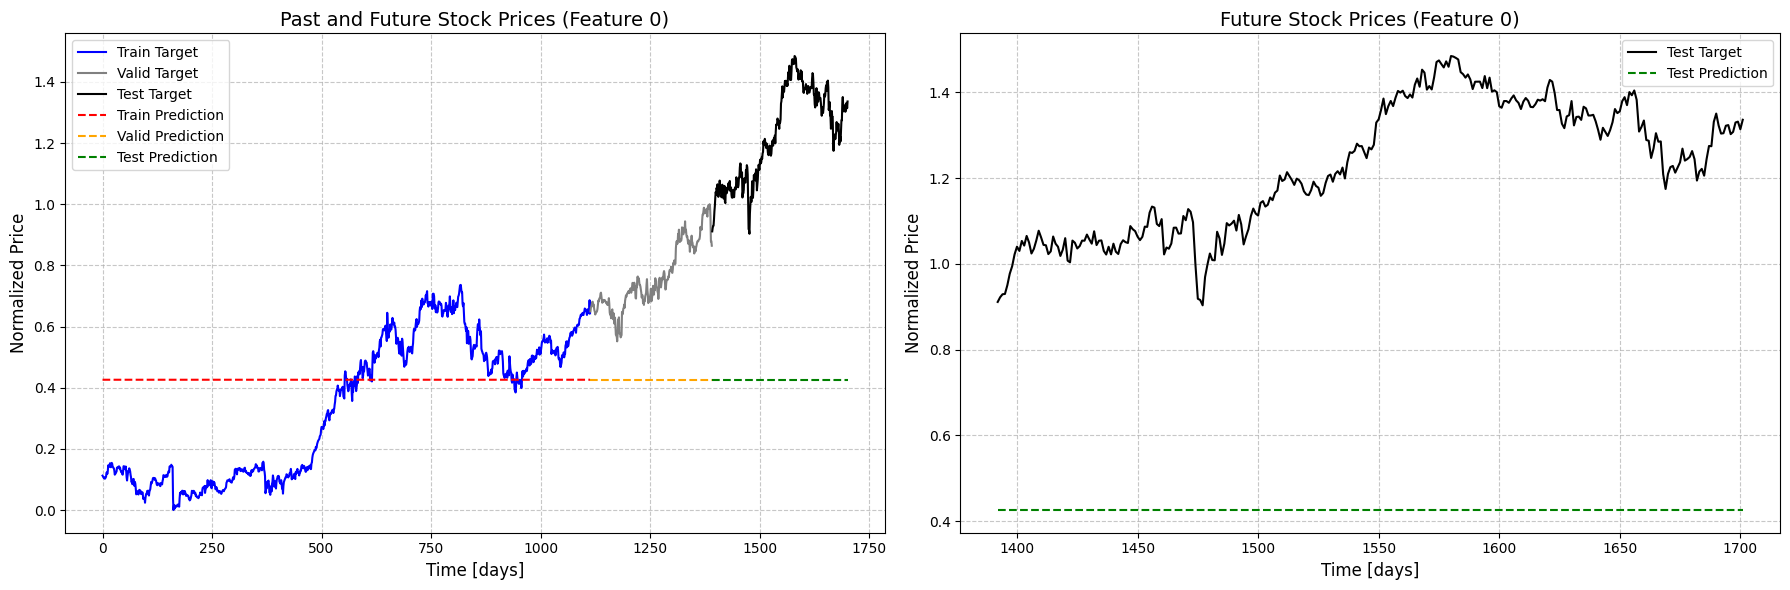


--- Correct Sign Prediction Correlation ---
Correct sign prediction for close - open price for train/valid/test: 0.34/0.59/0.61



In [38]:
# --- Custom Functions for Prediction Plotting and Correlation ---

def generate_predictions(model, x_train_tf, x_valid_tf, x_test_tf):
    """
    Generates predictions for train, validation, and test datasets using the trained model.

    Args:
        model (tf.keras.Model): The trained Keras model.
        x_train_tf (tf.Tensor): Training input data.
        x_valid_tf (tf.Tensor): Validation input data.
        x_test_tf (tf.Tensor): Test input data.

    Returns:
        tuple: A tuple containing NumPy arrays of predictions for train, valid, and test sets.
    """
    print("\n--- Generating Predictions ---")
    y_train_pred_np = model.predict(x_train_tf)
    y_valid_pred_np = model.predict(x_valid_tf)
    y_test_pred_np = model.predict(x_test_tf)

    print(f"y_train_pred_np shape: {y_train_pred_np.shape}")
    print(f"y_valid_pred_np shape: {y_valid_pred_np.shape}")
    print(f"y_test_pred_np shape: {y_test_pred_np.shape}")
    return y_train_pred_np, y_valid_pred_np, y_test_pred_np

def plot_predictions(y_train_actual, y_valid_actual, y_test_actual,
                     y_train_pred, y_valid_pred, y_test_pred, feature_index=0):
    """
    Plots the actual vs. predicted values for a specific feature on train, validation, and test sets.
    Includes two subplots: one for all sets, and one zoomed in on the test set.

    Args:
        y_train_actual (np.ndarray): Actual values for the training set.
        y_valid_actual (np.ndarray): Actual values for the validation set.
        y_test_actual (np.ndarray): Actual values for the test set.
        y_train_pred (np.ndarray): Predicted values for the training set.
        y_valid_pred (np.ndarray): Predicted values for the validation set.
        y_test_pred (np.ndarray): Predicted values for the test set.
        feature_index (int): The index of the feature to plot (e.g., 0 for 'open').
    """
    print("\n--- Plotting Predictions vs. Actuals ---")
    plt.figure(figsize=(18, 6)) # Adjusted overall figure size for two subplots

    # Subplot 1: Past and Future Stock Prices (Train, Validation, Test)
    plt.subplot(1, 2, 1)

    # Plot actual targets
    plt.plot(np.arange(y_train_actual.shape[0]), y_train_actual[:, feature_index], color='blue', label='Train Target')
    plt.plot(np.arange(y_train_actual.shape[0], y_train_actual.shape[0] + y_valid_actual.shape[0]),
             y_valid_actual[:, feature_index], color='gray', label='Valid Target')
    plt.plot(np.arange(y_train_actual.shape[0] + y_valid_actual.shape[0],
                       y_train_actual.shape[0] + y_valid_actual.shape[0] + y_test_actual.shape[0]),
             y_test_actual[:, feature_index], color='black', label='Test Target')

    # Plot predictions
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, feature_index], color='red', label='Train Prediction', linestyle='--')
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_valid_pred.shape[0]),
             y_valid_pred[:, feature_index], color='orange', label='Valid Prediction', linestyle='--')
    plt.plot(np.arange(y_train_pred.shape[0] + y_valid_pred.shape[0],
                       y_train_pred.shape[0] + y_valid_pred.shape[0] + y_test_pred.shape[0]),
             y_test_pred[:, feature_index], color='green', label='Test Prediction', linestyle='--')

    plt.title(f'Past and Future Stock Prices (Feature {feature_index})', fontsize=14)
    plt.xlabel('Time [days]', fontsize=12)
    plt.ylabel('Normalized Price', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)


    # Subplot 2: Future Stock Prices (Test Only)
    plt.subplot(1, 2, 2)

    # Plot actual test target
    plt.plot(np.arange(y_train_actual.shape[0] + y_valid_actual.shape[0],
                       y_train_actual.shape[0] + y_valid_actual.shape[0] + y_test_actual.shape[0]),
             y_test_actual[:, feature_index], color='black', label='Test Target')

    # Plot test prediction
    plt.plot(np.arange(y_train_actual.shape[0] + y_valid_actual.shape[0],
                       y_train_actual.shape[0] + y_valid_actual.shape[0] + y_test_pred.shape[0]),
             y_test_pred[:, feature_index], color='green', label='Test Prediction', linestyle='--')

    plt.title(f'Future Stock Prices (Feature {feature_index})', fontsize=14)
    plt.xlabel('Time [days]', fontsize=12)
    plt.ylabel('Normalized Price', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show()

def calculate_sign_correlation(y_actual, y_pred):
    """
    Calculates the correct sign prediction correlation for close - open price.

    Args:
        y_actual (np.ndarray): Actual values (e.g., y_train_actual_np, y_valid_actual_np).
        y_pred (np.ndarray): Predicted values (e.g., y_train_pred_np, y_valid_pred_np).

    Returns:
        float: The correlation value, or np.nan if not applicable.
    """
    if y_actual.shape[1] >= 2:
        # Calculate the sign of the difference between the second and first features (e.g., close - open)
        actual_sign = np.sign(y_actual[:, 1] - y_actual[:, 0])
        pred_sign = np.sign(y_pred[:, 1] - y_pred[:, 0])
        # Count where the signs match and divide by the total number of samples
        correlation = np.sum(np.equal(actual_sign, pred_sign).astype(int)) / y_actual.shape[0]
        return correlation
    else:
        return np.nan # Not applicable if less than two features

# --- Generate Predictions for Plotting (using custom function) ---
y_train_pred_np, y_valid_pred_np, y_test_pred_np = generate_predictions(
    model, x_train_tf, x_valid_tf, x_test_tf
)

# Convert actual TensorFlow Tensors to NumPy for plotting and calculations
y_train_actual_np = y_train_tf.numpy()
y_valid_actual_np = y_valid_tf.numpy()
y_test_actual_np = y_test_tf.numpy()

print("="*40 + "\n")


# --- Plotting Predictions vs. Actuals (Train, Validation, and Test - using custom function) ---
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest (assuming these map to your features)
plot_predictions(y_train_actual_np, y_valid_actual_np, y_test_actual_np,
                 y_train_pred_np, y_valid_pred_np, y_test_pred_np, feature_index=ft)


# --- Calculate Correct Sign Prediction Correlation (using custom function) ---
print("\n--- Correct Sign Prediction Correlation ---")

corr_price_development_train = calculate_sign_correlation(y_train_actual_np, y_train_pred_np)
corr_price_development_valid = calculate_sign_correlation(y_valid_actual_np, y_valid_pred_np)
corr_price_development_test = calculate_sign_correlation(y_test_actual_np, y_test_pred_np) # Calculate for test set

print('Correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train if not np.isnan(corr_price_development_train) else 0.0,
    corr_price_development_valid if not np.isnan(corr_price_development_valid) else 0.0,
    corr_price_development_test if not np.isnan(corr_price_development_test) else 0.0
))
print("="*40 + "\n")